# DETECCIÓN DEL FRAUDE EN SINIESTROS DE AUTOMÓVIL MEDIANTE APRENDIZAJE AUTOMÁTICO

In [1]:
#!pip install --user numpy==1.26.4
#!pip install --user scipy==1.11.4
#!pip install --user pandas==2.1.1
#!pip install --user matplotlib==3.7.2
#!pip install --user seaborn==0.12.2
#!pip install --user scikit-learn==1.7.2
#!pip install --user imbalanced-learn==0.13.12
#!pip install --user sweetviz==2.3.1
#!pip install --user shap==0.44.1
#!pip install --user lime==0.2.0.1
#!pip install --user llama-cpp-python==0.2.56

In [2]:
# Librerías
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, precision_score, accuracy_score, recall_score, f1_score,  classification_report, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import sweetviz as sv
from imblearn.over_sampling import SMOTE, RandomOverSampler
import json
import shap
from lime.lime_tabular import LimeTabularExplainer
from scipy.stats import randint, uniform
from imblearn.over_sampling import SMOTENC
import re
from llama_cpp import Llama

In [3]:
# Cargamos archivo
data = pd.read_csv("data/fraud_oracle.csv")

# 1. ANÁLISIS EXPLORATORIO

In [4]:
# Visualización de los primeros registros
data.head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [5]:
# Se extrae un registro para visualizar mejor los datos
data.iloc[11]

Month                                 Mar
WeekOfMonth                             5
DayOfWeek                          Monday
Make                                Honda
AccidentArea                        Urban
DayOfWeekClaimed                   Monday
MonthClaimed                          Mar
WeekOfMonthClaimed                      5
Sex                                  Male
MaritalStatus                     Married
Age                                    52
Fault                       Policy Holder
PolicyType              Sedan - Liability
VehicleCategory                     Sport
VehiclePrice               20000 to 29000
FraudFound_P                            0
PolicyNumber                           12
RepNumber                              13
Deductible                            400
DriverRating                            1
Days_Policy_Accident         more than 30
Days_Policy_Claim            more than 30
PastNumberOfClaims                 2 to 4
AgeOfVehicle                  more

### 1.1. DESCRIPCIÓN DE VARIABLES

In [6]:
# Detalle de la composición de los datos 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

- *Month*: mes en el que ocurrió el siniestro.
- *WeekOfMonth*: semana en la que ocurrió el siniestro. 
- *DayOfWeek*: día de la semana en que ocurrió el siniestro. 
- *Make*: marca del vehículo. 
- *AccidentArea*: localización del siniestro, rural o urbana. 
- *DayOfWeekClaimed*: día en el que se declaró el siniestro. 
- *MonthClaimed*: mes en el que se declaró el siniestro. 
- *WeekOfMonthClaimed*: semana del mes en la que se declaró el siniestro. 
- *Sex*: género de la persona del siniestro. 
- *MaritalStatus*: estado civil de la persona del siniestro. 
- *Age*: edad de la persona del siniestro.
- *Fault*: culpabilidad del siniestro. 
- *PolicyType*: combinación del tipo de vehículo y tipo de póliza: Liability (Terceros), Collision (Terceros con Pérdida Total), All Perils (Todo Riesgo). 
- *VehicleCatergory*: clasificación del tipo de vehículo. 
- *VehiclePrice*: valor del vehículo. 
- **FraudFound_P**: fraudulento o no (columna a predecir).
- *PolicyNumber*: número de siniestro correlativo.
- *RepNumber*:  ¿Repeticiones? entre 1 y 16
- *Deductible*: franquicia
- *DriverRating*: puntuación conductor.
- *Days_Policy_Accident*: periodo entre contratación de la Póliza y ocurrencia del siniestro. 
- *Days_Policy_Claim*: periodo entre contratación de la Póliza y declaración del siniestro. 
- *PastNumberOfClaims*: cantidad de siniestros declarados por el Tomador/Conductor. 
- *AgeOfVehicle*: antigüedad del vehículo.
- *AgeOfPolicyHolder*: edad del Tomador/Conductor.
- *PoliceReportFiled*: existe denuncia.
- *WitnessPresent*: hay testigos.
- *AgentType*: -internos(el fraude es realizado por personal de la Compañía)
               -externos(los fraudes son diversos como pueden ser proveedores de servicios, beneficiarios, asegurados...)
- *NumberOfSuppliments*: número de suplementos.
- *AddressChange_Claim*: cambio de dirección del Tomador/Conductor tras declarar el siniestro. 
- *NumberOfCars*: número de vehículos involucrados.
- *Year*: año ocurrencia del siniestro.
- *BasePolicy*: tipo de póliza(igual a PolicyType). 

In [7]:
# Exploración de valores únicos
for column in data:
    print(column)
    print(sorted(data[column].unique()),"\n")

Month
['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'] 

WeekOfMonth
[1, 2, 3, 4, 5] 

DayOfWeek
['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'] 

Make
['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda', 'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson', 'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW'] 

AccidentArea
['Rural', 'Urban'] 

DayOfWeekClaimed
['0', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'] 

MonthClaimed
['0', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'] 

WeekOfMonthClaimed
[1, 2, 3, 4, 5] 

Sex
['Female', 'Male'] 

MaritalStatus
['Divorced', 'Married', 'Single', 'Widow'] 

Age
[0, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 7

In [8]:
# Exploración de valores nulos/faltantes
for columna in data.columns:
    ceros = (data[columna] == 0).sum() + (data[columna] == '0').sum()
    
    print(f"Columna {columna}:{ceros}")
    print("-" * 40)

Columna Month:0
----------------------------------------
Columna WeekOfMonth:0
----------------------------------------
Columna DayOfWeek:0
----------------------------------------
Columna Make:0
----------------------------------------
Columna AccidentArea:0
----------------------------------------
Columna DayOfWeekClaimed:1
----------------------------------------
Columna MonthClaimed:1
----------------------------------------
Columna WeekOfMonthClaimed:0
----------------------------------------
Columna Sex:0
----------------------------------------
Columna MaritalStatus:0
----------------------------------------
Columna Age:320
----------------------------------------
Columna Fault:0
----------------------------------------
Columna PolicyType:0
----------------------------------------
Columna VehicleCategory:0
----------------------------------------
Columna VehiclePrice:0
----------------------------------------
Columna FraudFound_P:14497
----------------------------------------
Co

NOTA: Solo se observan dos valores faltantes en las variables DayOfWeekClaimed y MonthClaimed que se eliminarán durante el preprocesado. Por otra parte, se estudian los 320 valores faltantes en la variable Age para encontrar su origen y evaluar cómo proceder. Tambiés se ha observado un error en entre las variables Age/AgeOfPolicyHolder que habrá que subsanar durante el preprocesado.

In [9]:
# Análisis del tipo de datos que son los 320 registros con nulos en la variable de edad
data[data['Age']==0].head()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
7,Nov,1,Friday,Honda,Urban,Tuesday,Mar,4,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
13,Jan,5,Friday,Honda,Rural,Wednesday,Feb,1,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
28,Jul,1,Saturday,Honda,Urban,Tuesday,Sep,4,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils
31,Mar,1,Sunday,Honda,Urban,Tuesday,Mar,2,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Collision
58,May,1,Monday,Honda,Rural,Wednesday,May,4,Male,Single,...,new,16 to 17,No,No,External,none,no change,1 vehicle,1994,Liability


In [10]:
# Exploración de valores únicos
for column in data:
    print(column)
    print(sorted(data[column].unique()),"\n")

Month
['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'] 

WeekOfMonth
[1, 2, 3, 4, 5] 

DayOfWeek
['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'] 

Make
['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda', 'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson', 'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW'] 

AccidentArea
['Rural', 'Urban'] 

DayOfWeekClaimed
['0', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'] 

MonthClaimed
['0', 'Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'] 

WeekOfMonthClaimed
[1, 2, 3, 4, 5] 

Sex
['Female', 'Male'] 

MaritalStatus
['Divorced', 'Married', 'Single', 'Widow'] 

Age
[0, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 7

In [11]:
# Exploración de las variables categóricas
categoricas = data.select_dtypes(include=['object']).columns

for col in categoricas:
    print(f"\n>>> Columna: {col}")
    print(data[col].value_counts(dropna=False)) 


>>> Columna: Month
Month
Jan    1411
May    1367
Mar    1360
Jun    1321
Oct    1305
Dec    1285
Apr    1280
Feb    1266
Jul    1257
Sep    1240
Nov    1201
Aug    1127
Name: count, dtype: int64

>>> Columna: DayOfWeek
DayOfWeek
Monday       2616
Friday       2445
Tuesday      2300
Thursday     2173
Wednesday    2159
Saturday     1982
Sunday       1745
Name: count, dtype: int64

>>> Columna: Make
Make
Pontiac      3837
Toyota       3121
Honda        2801
Mazda        2354
Chevrolet    1681
Accura        472
Ford          450
VW            283
Dodge         109
Saab          108
Mercury        83
Saturn         58
Nisson         30
BMW            15
Jaguar          6
Porche          5
Mecedes         4
Ferrari         2
Lexus           1
Name: count, dtype: int64

>>> Columna: AccidentArea
AccidentArea
Urban    13822
Rural     1598
Name: count, dtype: int64

>>> Columna: DayOfWeekClaimed
DayOfWeekClaimed
Monday       3757
Tuesday      3375
Wednesday    2951
Thursday     2660
Friday    

In [12]:
# Exploración de las variables cuantitativas
cuantitativas = ['FraudFound_P', 'Deductible', 'Age']

for col in cuantitativas:
    print(f"\n>>> Columna: {col}")
    print(data[col].value_counts().sort_index())


>>> Columna: FraudFound_P
FraudFound_P
0    14497
1      923
Name: count, dtype: int64

>>> Columna: Deductible
Deductible
300        8
400    14838
500      263
700      311
Name: count, dtype: int64

>>> Columna: Age
Age
0     320
16      9
17      6
18     48
19     32
     ... 
76     42
77     29
78     35
79     20
80     32
Name: count, Length: 66, dtype: int64


                                             |          | [  0%]   00:00 -> (? left)


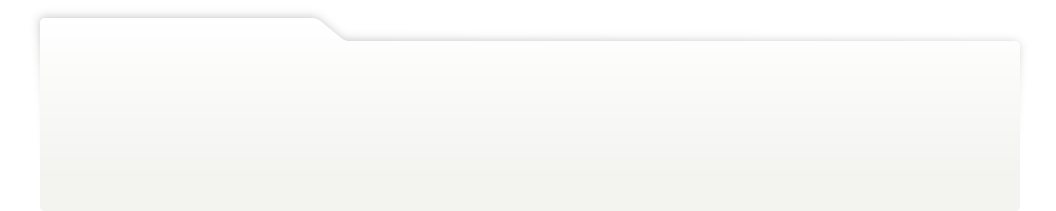
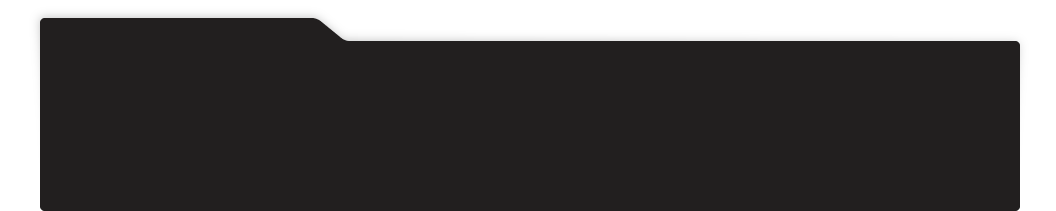
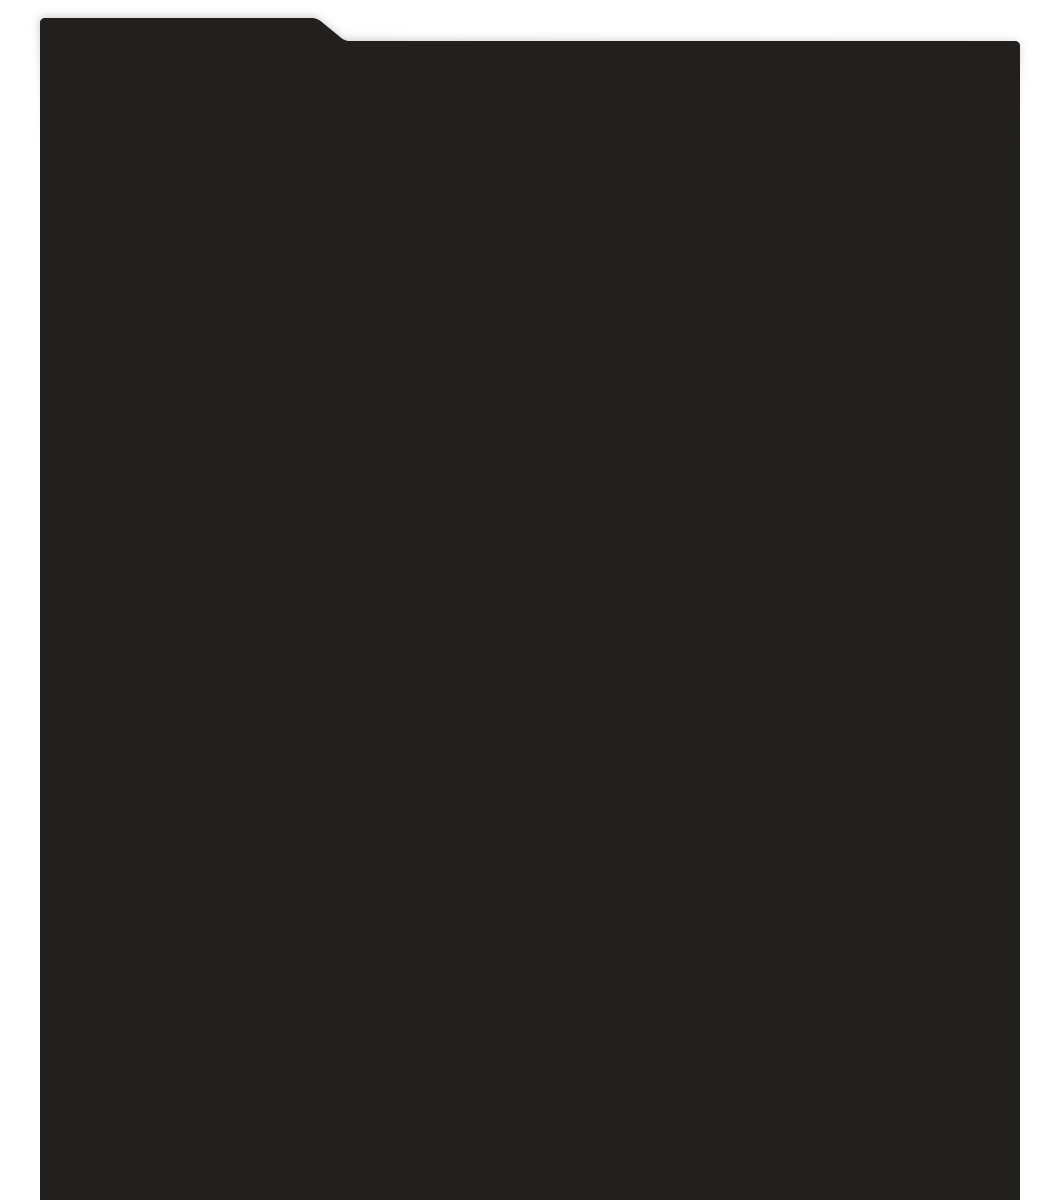
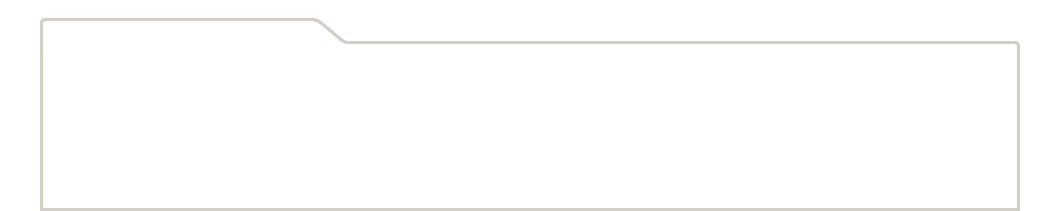
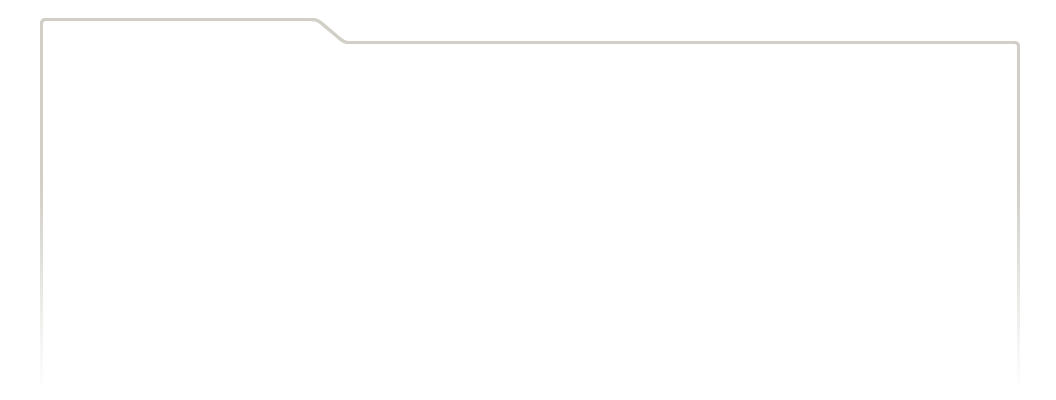
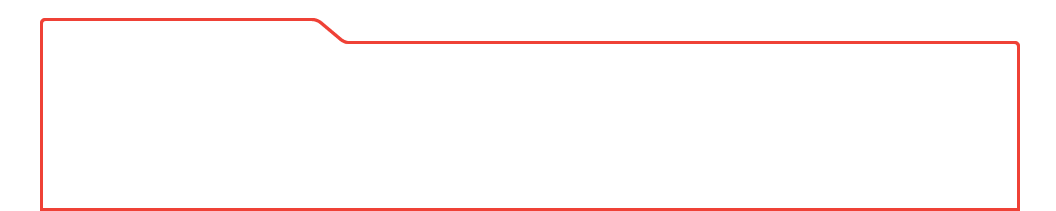
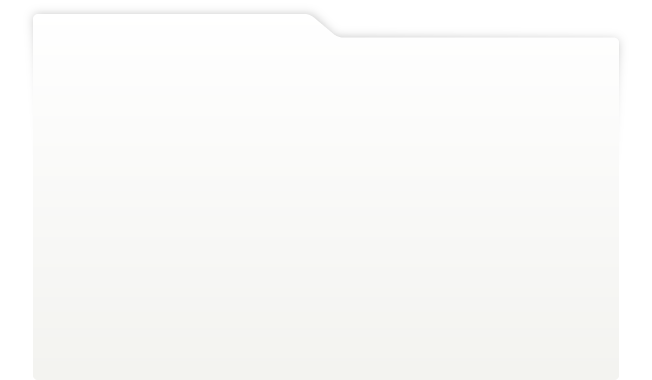
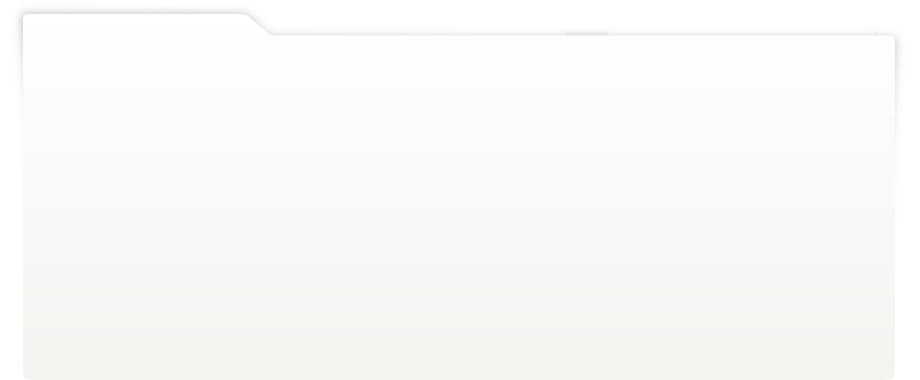
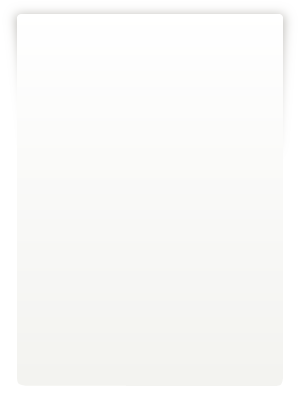
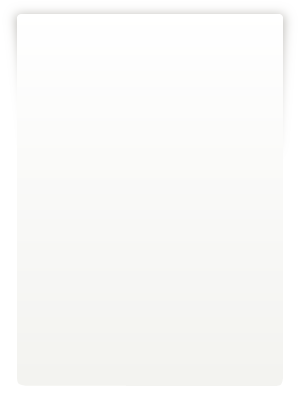
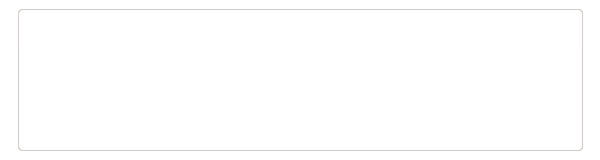
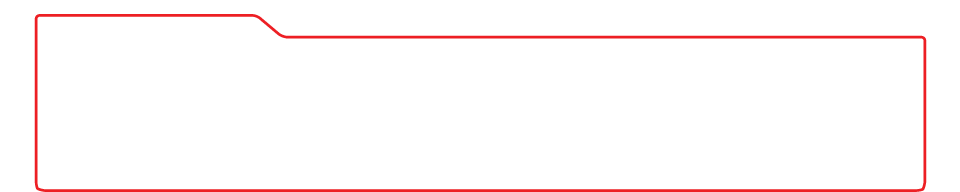
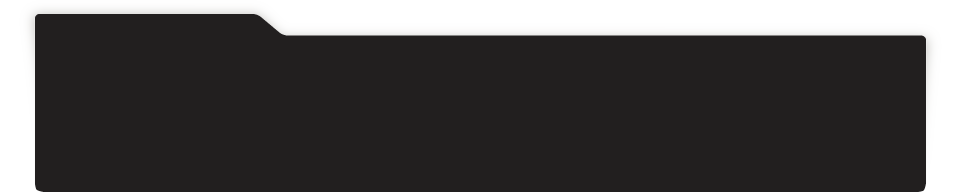
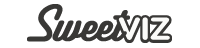
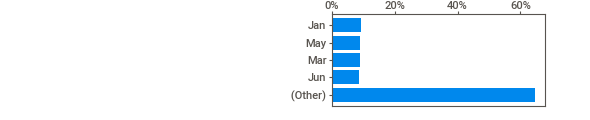
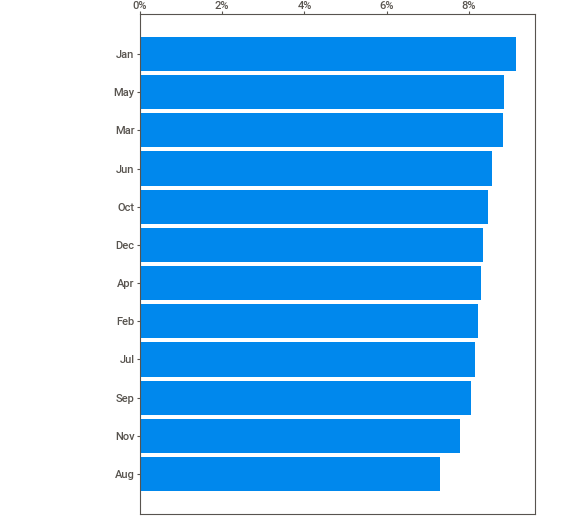
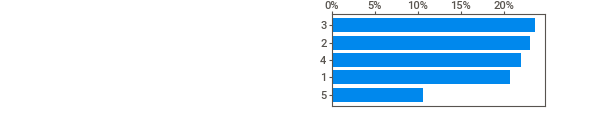
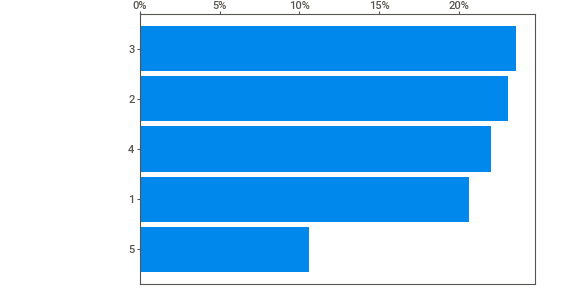
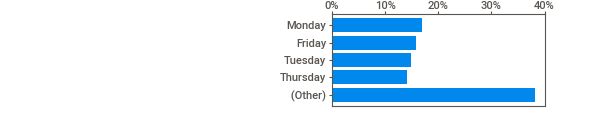
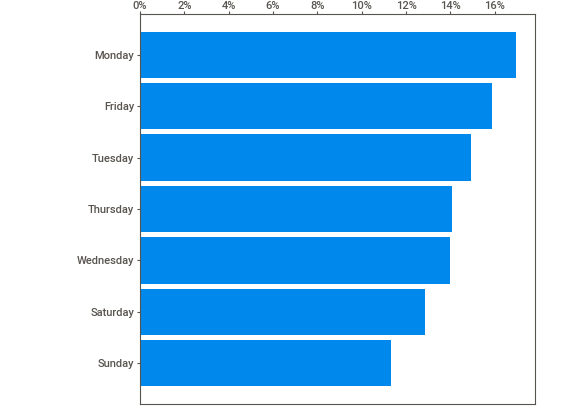
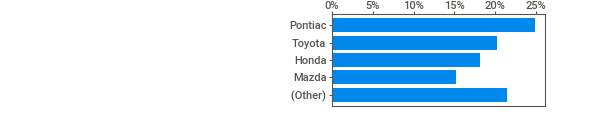
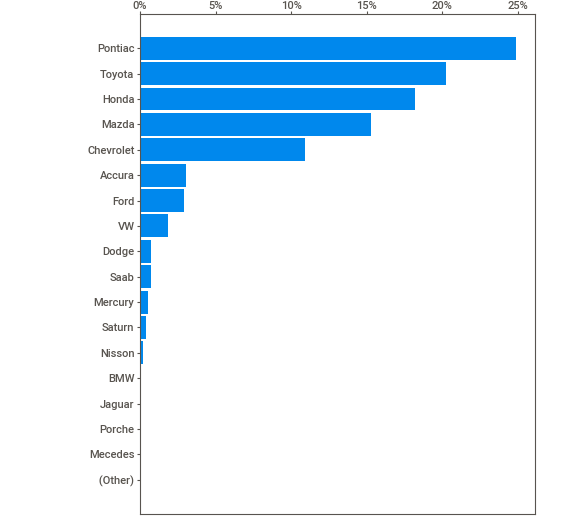
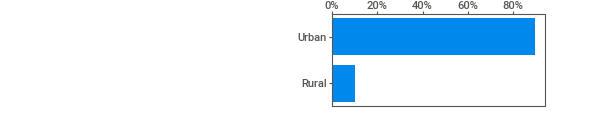
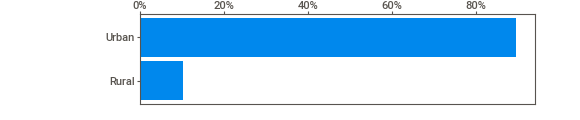
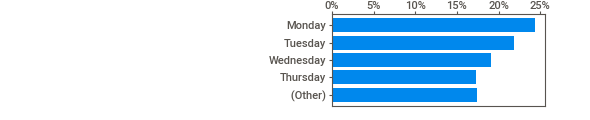
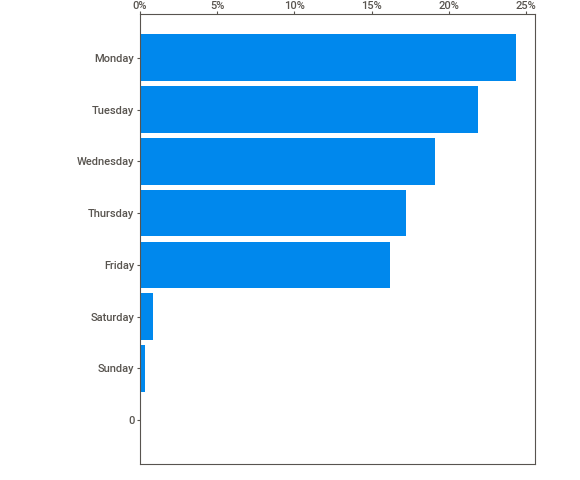
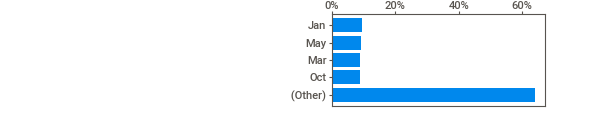
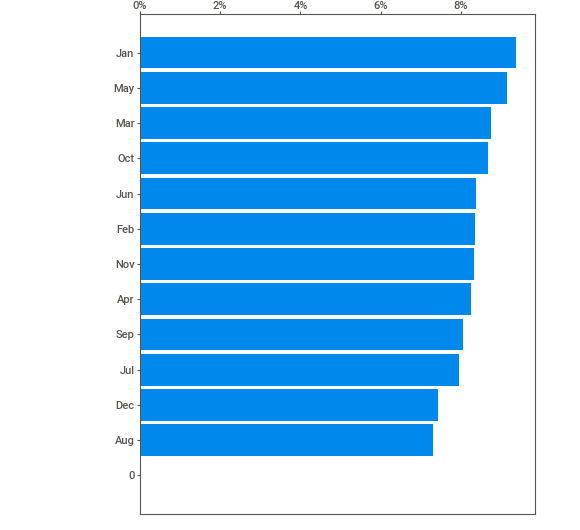
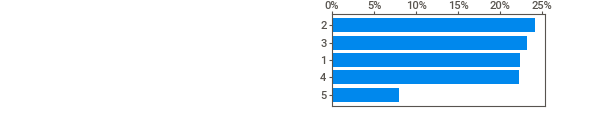
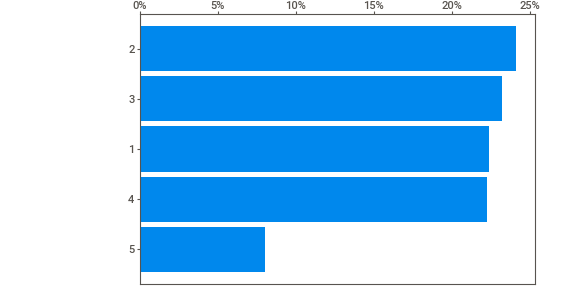
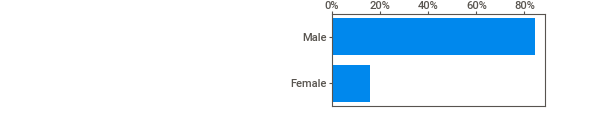
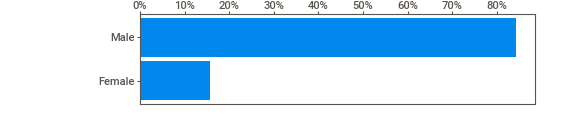
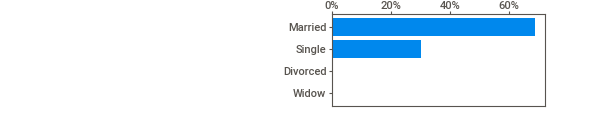
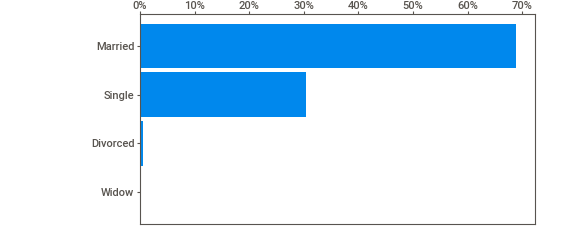
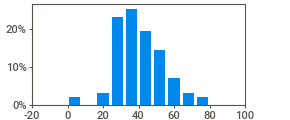
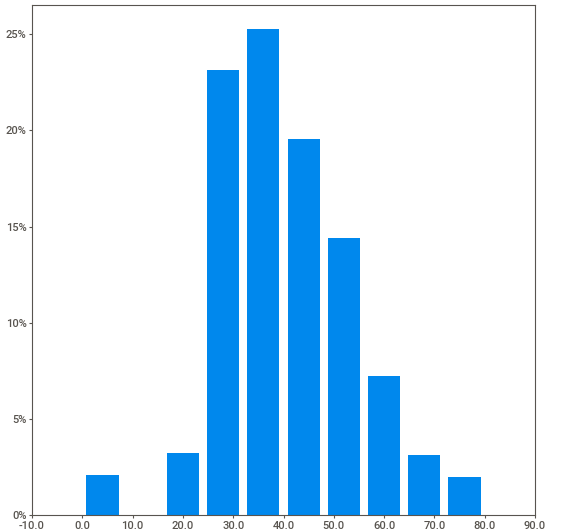
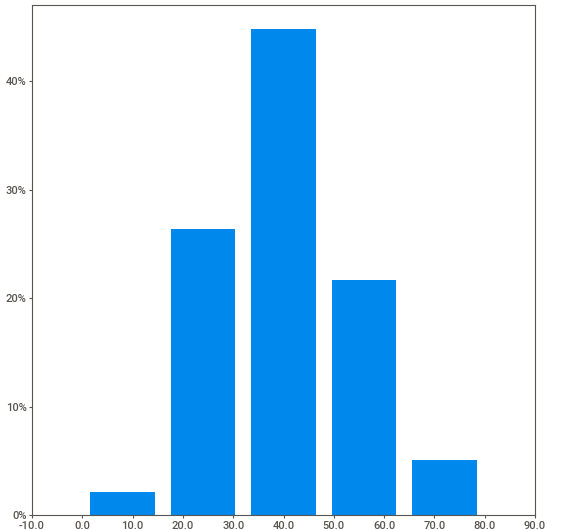
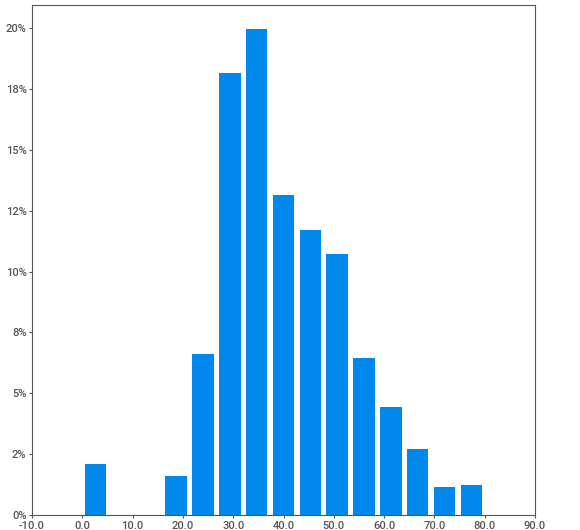
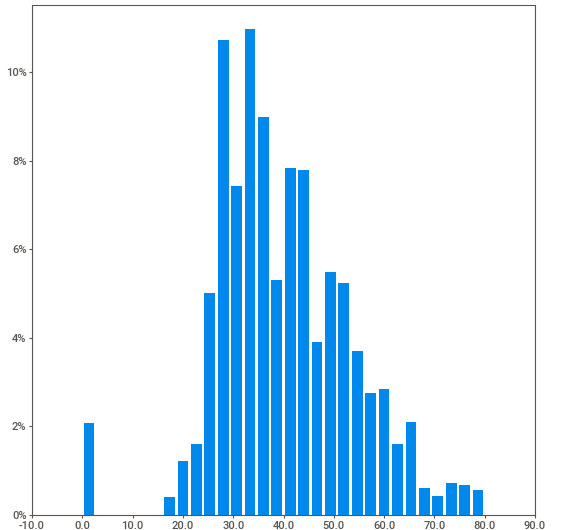
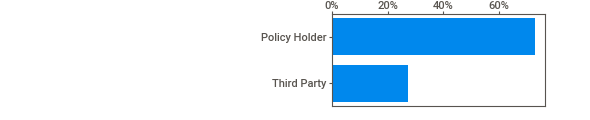
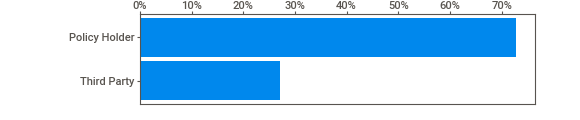
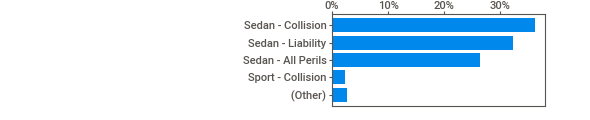
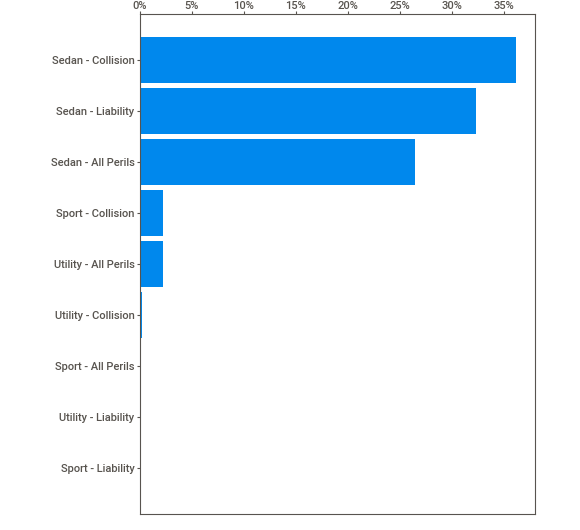
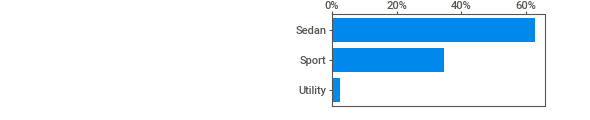
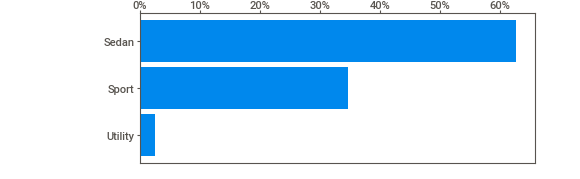
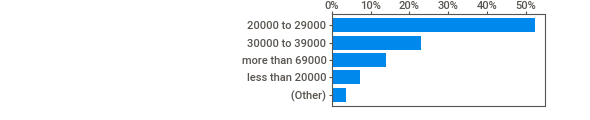
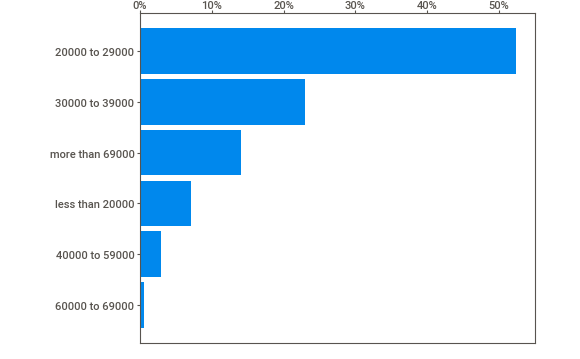
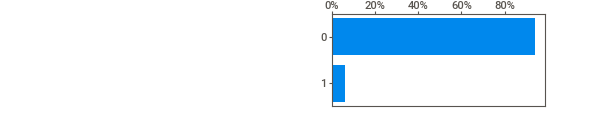
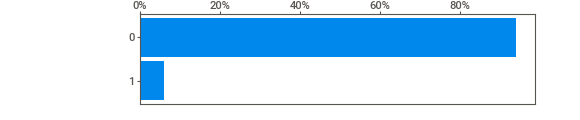
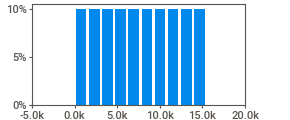
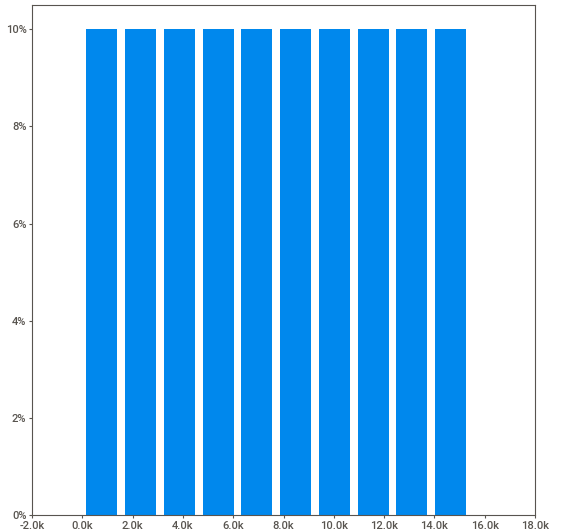
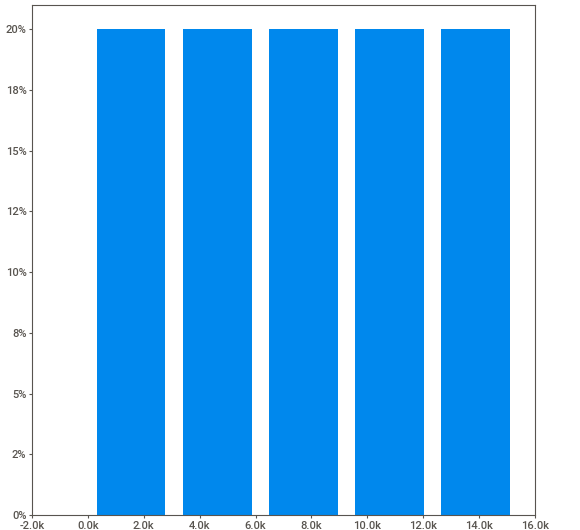
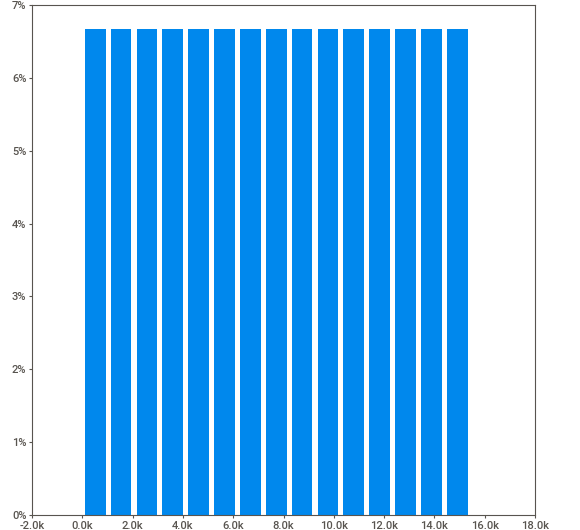
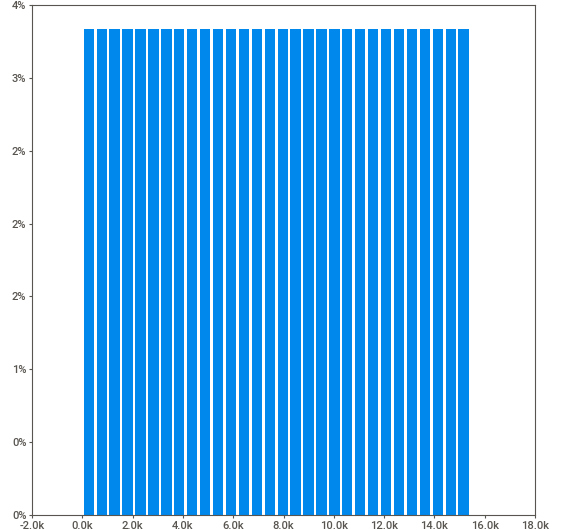
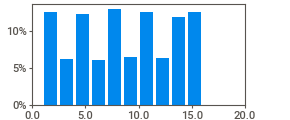
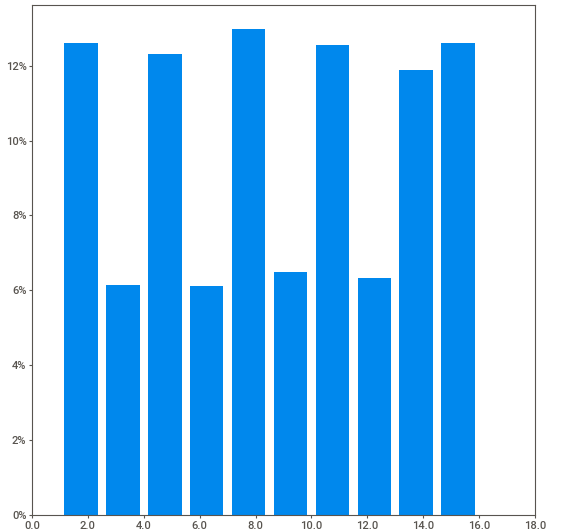
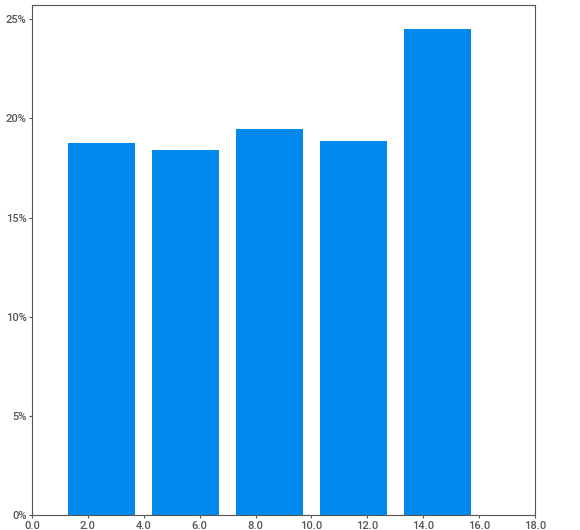
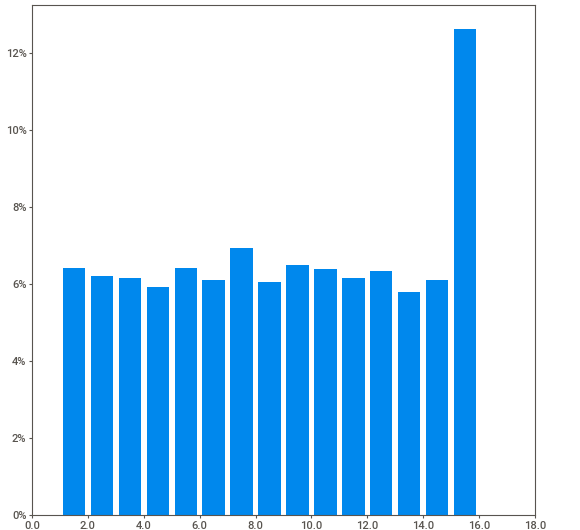
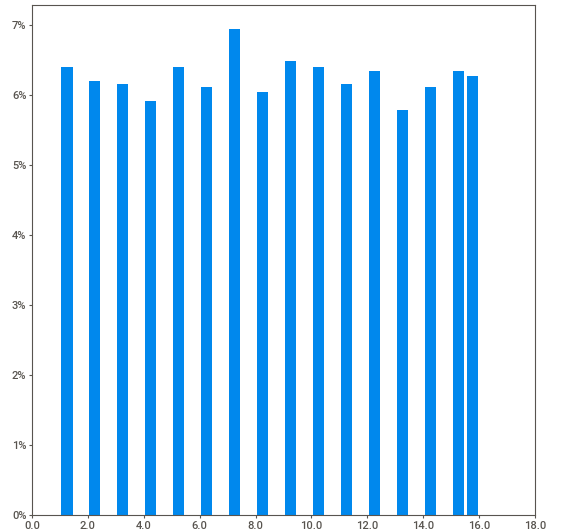
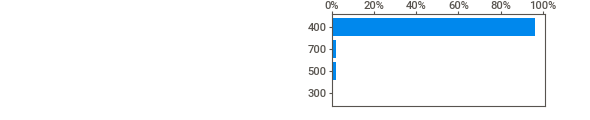
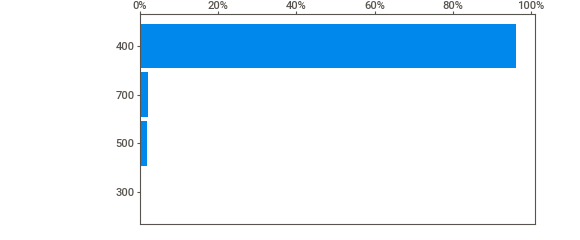
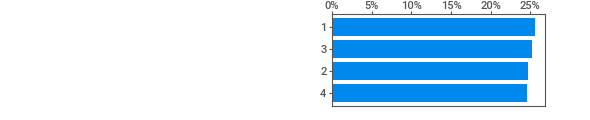
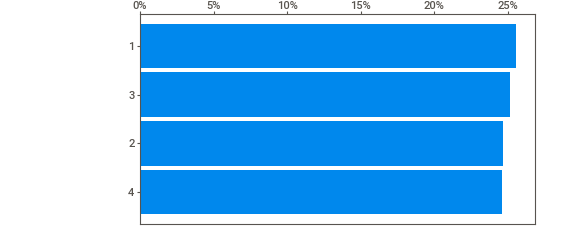
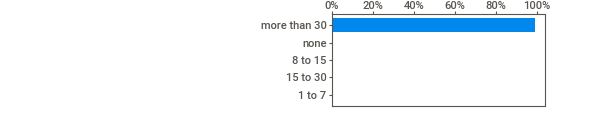
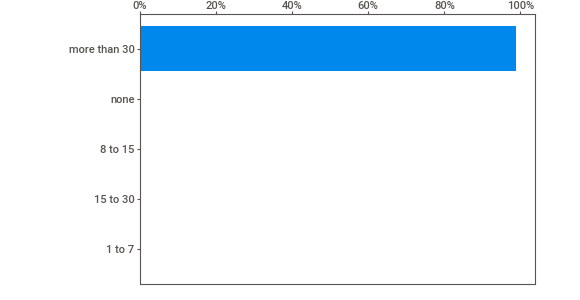
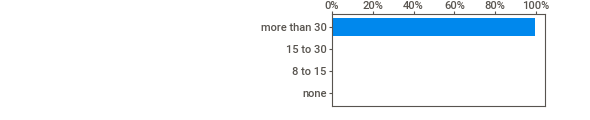
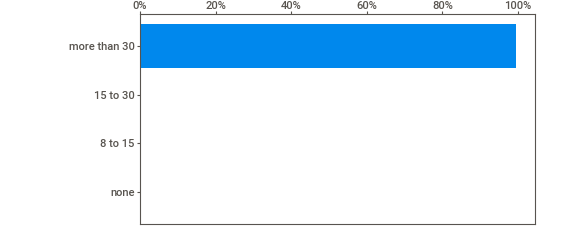
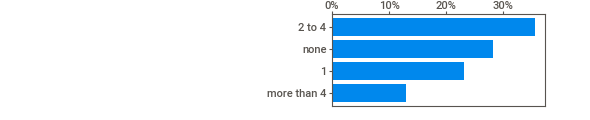
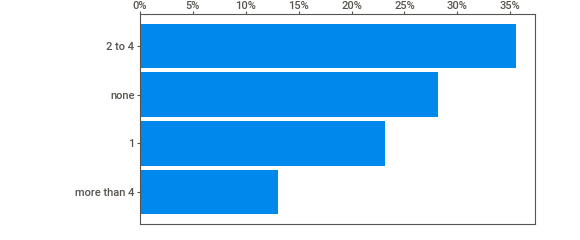
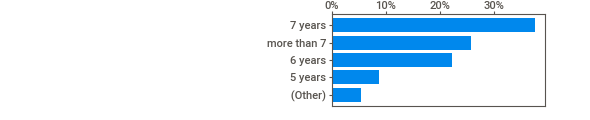
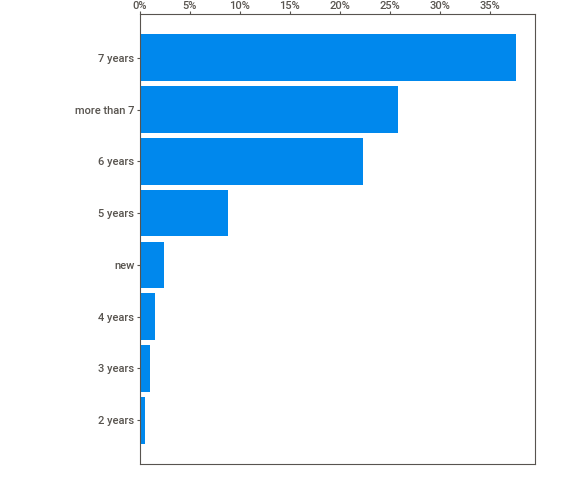
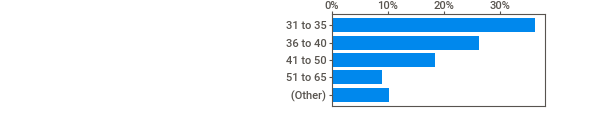
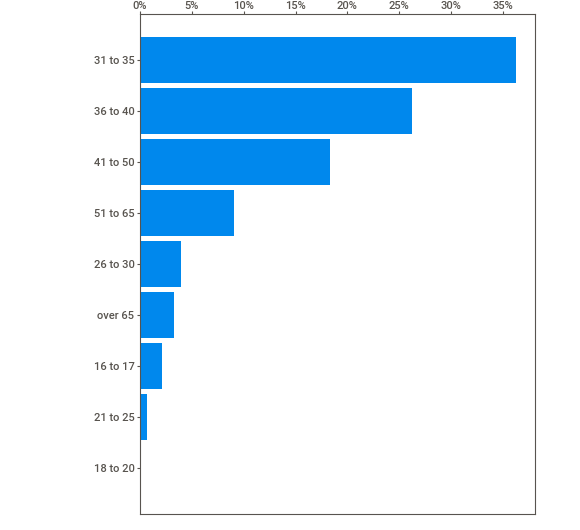
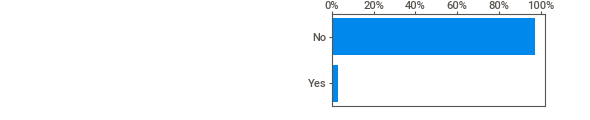
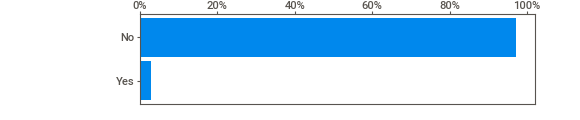
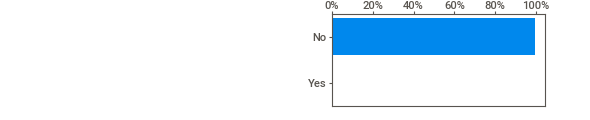
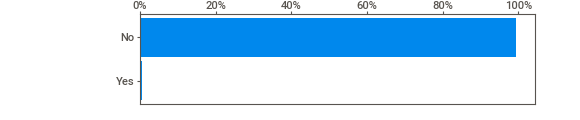
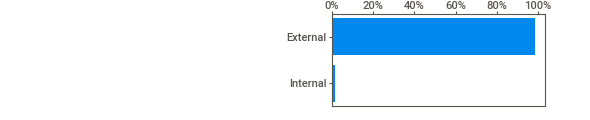
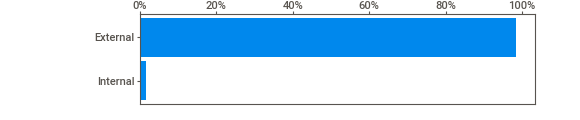
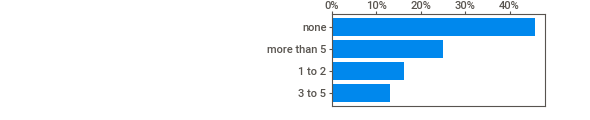
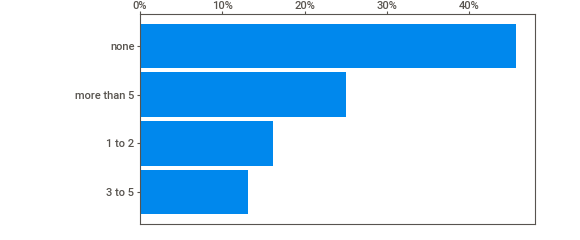
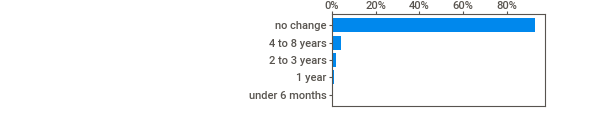
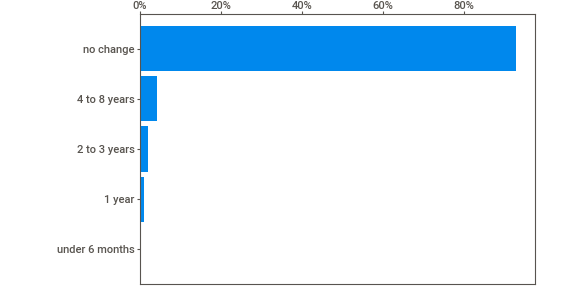
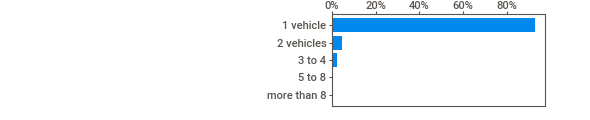
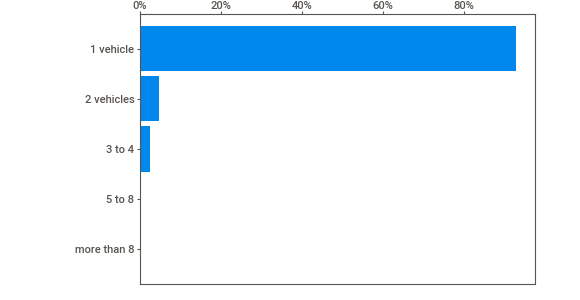
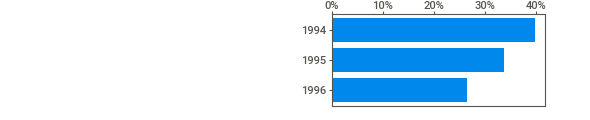
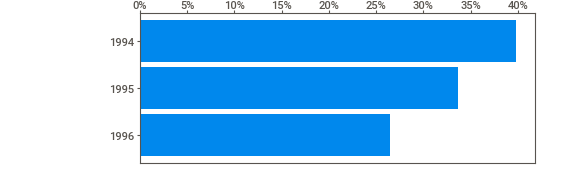
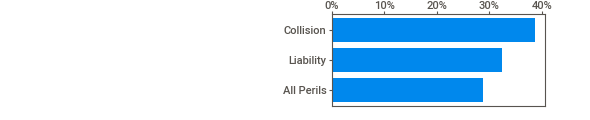
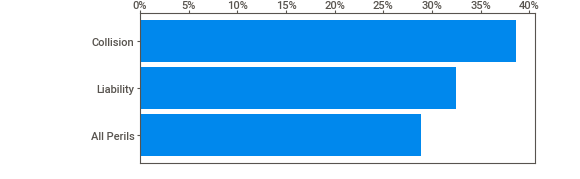
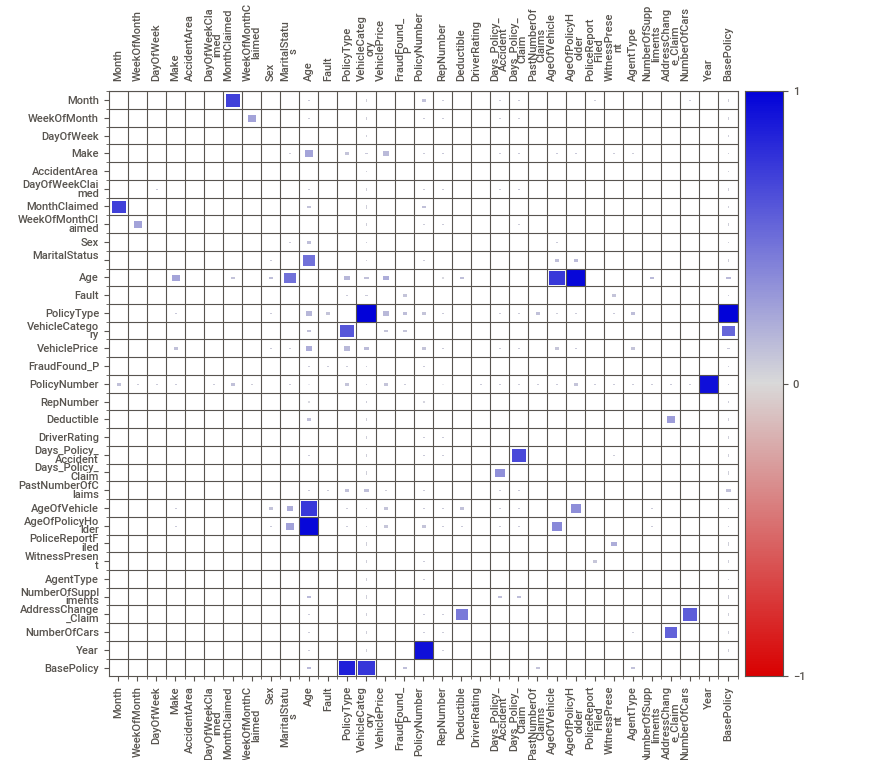
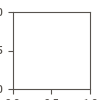

Report EDA_Sweetviz_Fraude_Automovil.html was generated.


In [13]:
# Visualizamos los datos del dataset antes del tratamiento
preprocessing = sv.analyze(data)
preprocessing.show_notebook()

preprocessing.show_html(
    filepath="EDA_Sweetviz_Fraude_Automovil.html",
    open_browser=False
)

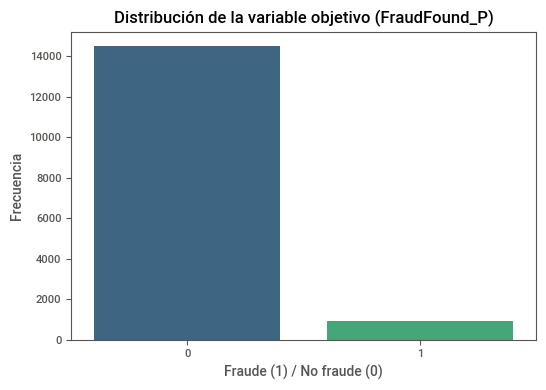

In [14]:
# Distribución de la variable objetivo
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='FraudFound_P', palette='viridis')
plt.title("Distribución de la variable objetivo (FraudFound_P)")
plt.xlabel("Fraude (1) / No fraude (0)")
plt.ylabel("Frecuencia")
plt.show()

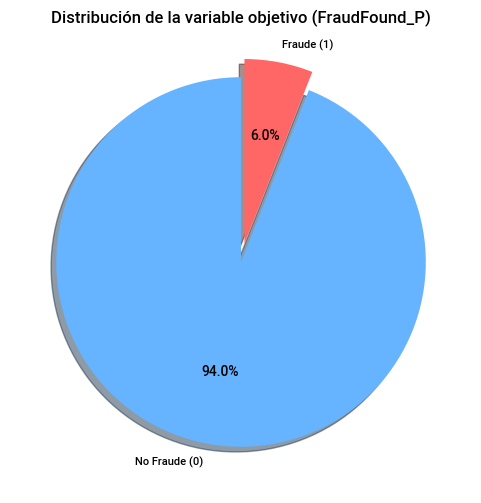

In [15]:
# Pie chart del target
fraud_counts = data['FraudFound_P'].value_counts()
labels = ['No Fraude (0)', 'Fraude (1)']
colors = ['#66b3ff', '#ff6666']

plt.figure(figsize=(6,6))
plt.pie(
    fraud_counts, 
    labels=labels, 
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=[0, 0.1],  # separa un poco el segmento de fraude para destacarlo
    shadow=True
)
plt.title("Distribución de la variable objetivo (FraudFound_P)")
plt.show()

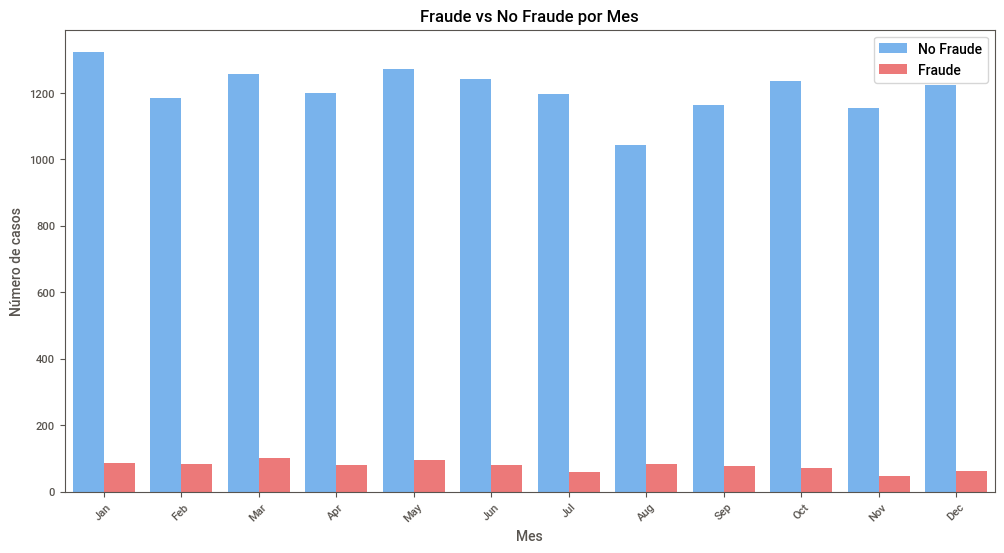

In [16]:
# Distribución de las variables Month  fraude vs no fraude
plt.figure(figsize=(12,6))
order = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

sns.countplot(
    data=data,
    x='Month',
    hue='FraudFound_P',
    order=order,
    palette=['#66b3ff','#ff6666']
)

plt.title("Fraude vs No Fraude por Mes")
plt.xlabel("Mes")
plt.ylabel("Número de casos")
plt.legend(labels=['No Fraude','Fraude'])
plt.xticks(rotation=45)
plt.show()

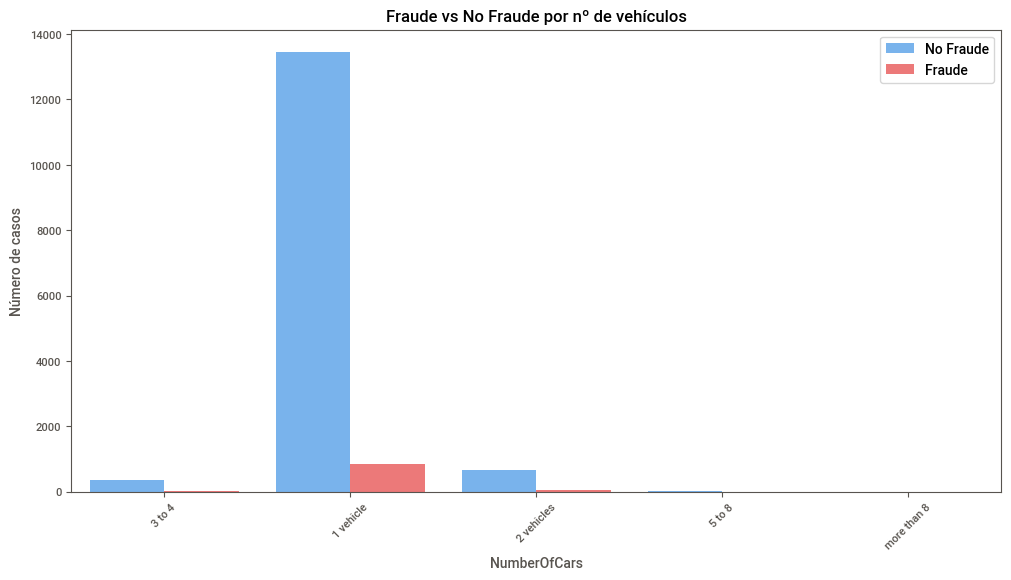

In [17]:
# Distribución de las variable Nº vehículos  fraude vs no fraude
plt.figure(figsize=(12,6))

sns.countplot(
    data=data,
    x='NumberOfCars',
    hue='FraudFound_P',
    #order=order,
    palette=['#66b3ff','#ff6666']
)

plt.title("Fraude vs No Fraude por nº de vehículos")
plt.ylabel("Número de casos")
plt.legend(labels=['No Fraude','Fraude'])
plt.xticks(rotation=45)
plt.show()

**CONCLUSIONES**

En la exploración inicial se detectan patrones descriptivos en frecuencia, aunque aún no se puede afirmar su relación con el fraude hasta analizar la proporción de casos fraudulentos en cada categoría y estudiar la correlación con la variable objetivo.

De manera preliminar, se observan desequilibrios en múltiples variables que deberán tratarse mediante codificación, balanceo y evaluación de importancia dentro de los modelos. La estrategia a llevar a cabo será eliminar las variales más irrelevantes para el modelo y balancear aquellas vitales para evitar un posible sesgo en el algoritmo.

La variable PolicyType contiene la información de las variables VehicleCategory y BasePolicy por lo que no aporta información nueva. La variable PolicyNumber es una numeración que tampoco aporta información al modelo, así como RepNumber. La variable DriverRating no aporta variabilidad al modelo por su distribución homogénea. Las variables DaysPolicyClaim y DaysPolicyAccident presentan poca información por lo que se valorará su supresión. La variable AdressChangeClaim no aporta información adicional ya que la mayoría no ha cambiado de dirección. La variable Year tampoco aporta mucha información.

Los valores faltantes en Age se sospecha que corresponden con tomadores del rango de edad entre 16 y 17 años. También se ha observado que existen inconsistencias en ciertas variables como Age/AgeOfPolicyHolder.


# 2. PREPROCESADO DEL DATASET

## 2.1. LIMPIEZA E IMPUTACIÓN DE VALORES FALTANTES

In [18]:
# Eliminación de tres registros sin información en las variables del día de la semana y mes del siniestro
data = data[(data['DayOfWeekClaimed'] != '0') & (data['MonthClaimed'] != '0')].copy()

In [19]:
data.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'PolicyType', 'VehicleCategory',
       'VehiclePrice', 'FraudFound_P', 'PolicyNumber', 'RepNumber',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

In [20]:
# Comprobación de registros faltantes en Age pertenecen a rango de edad 16 a 17
n = ((data['Age'] == 0) & (data['AgeOfPolicyHolder'] == '16 to 17')).sum()
print("Número de registros con Age = 0 y AgeOfPolicyHolder = '16 to 17':", n)

Número de registros con Age = 0 y AgeOfPolicyHolder = '16 to 17': 319


NOTA: se observa que los 320 registros detectados con edad 0 corresponden al grupo de rango de edad de entre 16 a 17(319 y otro fue eliminado en el paso anterior), por lo que se descarta la eliminación de registros ya que se perdería información importante para la correcta detección de fraudes. Para no deformar la distribución original, se van a plicar por porcentajes los 320 registros.

In [21]:
# Imputación de valores faltantes
ceros = (data['Age'] == 0) & (data['AgeOfPolicyHolder'] == '16 to 17')
total_real = (data['Age'].isin([16,17])).sum()
p_16 = (data['Age'] == 16).sum() / total_real
p_17 = (data['Age'] == 17).sum() / total_real

data.loc[ceros, 'Age'] = np.random.choice(
    [16, 17],
    size=ceros.sum(),
    p=[p_16, p_17]
)

In [22]:
data['Age'].value_counts().sort_index()

Age
16    205
17    129
18     48
19     32
20     28
     ... 
76     42
77     29
78     35
79     20
80     32
Name: count, Length: 65, dtype: int64

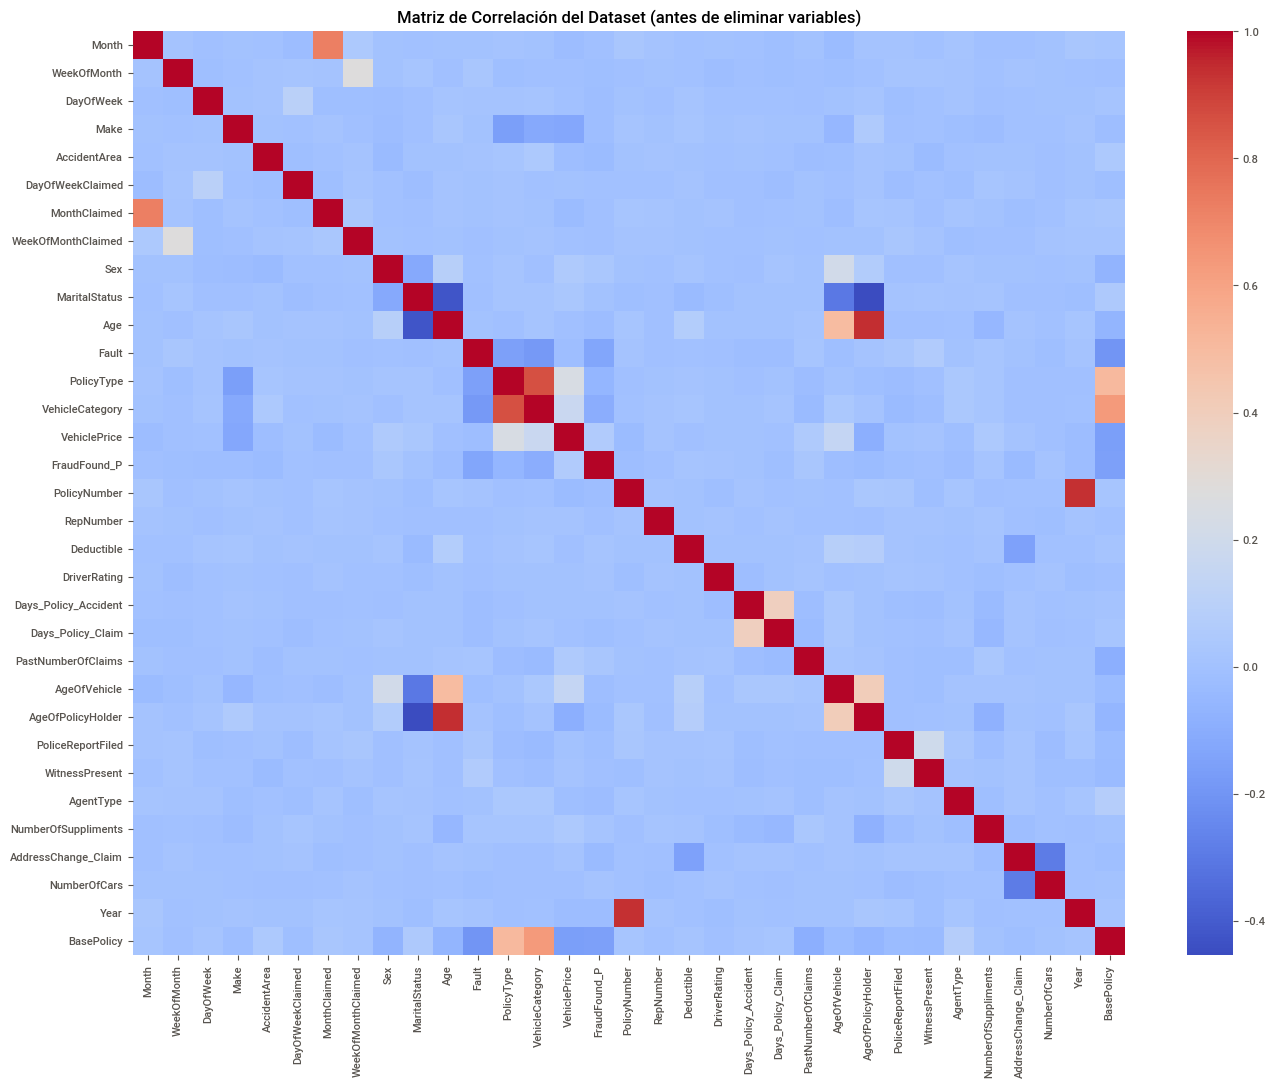

In [23]:
# Convertir momentáneamente variables categóricas a códigos numéricos para correlación
data_corr = data.copy()
for col in data_corr.select_dtypes(include='object'):
    data_corr[col] = data_corr[col].astype('category').cat.codes

# Matriz de correlación
plt.figure(figsize=(16,12))
sns.heatmap(data_corr.corr(), cmap='coolwarm', annot=False)
plt.title("Matriz de Correlación del Dataset (antes de eliminar variables)")
plt.show()

La matriz de correlación revela que la mayoría de variables del dataset presentan relaciones lineales débiles entre sí, lo cual es característico de datos categóricos y dispersos asociados a siniestros de automóviles. Únicamente se detecta una relación fuerte entre PolicyType, VehicleCategory y BasePolicy, lo que confirma la redundancia de PolicyType y justifica su eliminación. Asimismo, variables como Days_Policy_Claim, Days_Policy_Accident, WitnessPresent, PoliceReportFiled, AgentType y NumberOfCars muestran muy baja variabilidad y correlación prácticamente nula con el resto, por lo que apenas aportan información útil para los modelos predictivos. La variable objetivo FraudFound_P no correlaciona de forma relevante con ningún predictor, lo que sugiere que el fraude es un fenómeno complejo dependiente de la interacción entre múltiples factores y que será mejor capturado mediante modelos no lineales como Random Forest o XGBoost.

In [24]:
# Estudiar varias variables candidatas a eliminar para reduri dimensionalidad
vars = [
    'PolicyNumber',        
    'RepNumber',           
    'PolicyType',          
    'DriverRating',        
    'AddressChange_Claim', 
    'Days_Policy_Claim',   
    'Days_Policy_Accident',
    'Year'
]

for col in vars:
    print(f"\nVariable: {col}")
    if col not in data:
        print("No estaba en el dataset o ya fue transformada.")
        continue

    tabla = (
        data.groupby(col)['FraudFound_P']
        .agg(['count', 'sum'])
        .rename(columns={"count":"total", "sum":"fraudes"})
    )
    tabla['fraud_rate'] = tabla['fraudes'] / tabla['total']
    print(tabla.sort_values('fraud_rate', ascending=False))



Variable: PolicyNumber
              total  fraudes  fraud_rate
PolicyNumber                            
15420             1        1         1.0
1889              1        1         1.0
13626             1        1         1.0
13631             1        1         1.0
6279              1        1         1.0
...             ...      ...         ...
5315              1        0         0.0
5316              1        0         0.0
5317              1        0         0.0
5318              1        0         0.0
7711              1        0         0.0

[15419 rows x 3 columns]

Variable: RepNumber
           total  fraudes  fraud_rate
RepNumber                            
6            942       66    0.070064
7           1069       74    0.069224
10           986       66    0.066937
9            999       65    0.065065
13           892       58    0.065022
1            987       63    0.063830
3            949       60    0.063224
14           941       57    0.060574
11           948

In [25]:
cols_to_drop = [
    # Redundancia
    'PolicyType',
    'PolicyNumber',
    'RepNumber'
]

data = data.drop(columns=cols_to_drop, errors='ignore')

print("Variables eliminadas:", cols_to_drop)
print("Dimensiones finales:", data.shape)

Variables eliminadas: ['PolicyType', 'PolicyNumber', 'RepNumber']
Dimensiones finales: (15419, 30)


**Variables eliminadas**

- PolicyType: variable redundante que combina información ya presente en VehicleCategory y BasePolicy, generando multicolinealidad.
- PolicyNumber: identificador único sin información predictiva; genera ruido.
- RepNumber: metadato operativo sin relación con el fraude; no aporta valor al modelo.

In [26]:
# Corrección de variable AgeOfPolicyHolder en función de nuevos tramos para reducir etiquetas
bins = [0, 20, 30, 40, 50, 65, np.inf]
labels = ['16 to 20', '21 to 30', '31 to 40', '41 to 50', '51 to 65', 'over 65']
data['AgeOfPolicyHolder'] = pd.cut(data['Age'], bins=bins, labels=labels, right=True, include_lowest=True)

# Verificar resultado
data[['Age', 'AgeOfPolicyHolder']].head(10)

,Age,AgeOfPolicyHolder
0,21,21 to 30
1,34,31 to 40
2,47,41 to 50
3,65,51 to 65
4,27,21 to 30
5,20,16 to 20
6,36,31 to 40
7,17,16 to 20
8,30,21 to 30
9,42,41 to 50


RESUMEN

Aunque el Análisis de Componentes Principales (PCA) es una técnica habitual para reducir dimensionalidad, en este proyecto no se ha empleado como método principal debido a la naturaleza del dataset. La mayoría de las variables son categóricas y no representan magnitudes continuas, lo que limita la interpretabilidad del PCA y reduce su eficacia. Además, la correlación lineal entre variables es muy baja, por lo que no existe una estructura latente que pueda resumirse mediante componentes principales. Finalmente, los modelos utilizados (Árboles, Random Forest y XGBoost) no requieren reducción de dimensionalidad previa y gestionan adecuadamente espacios con alto número de variables. Por estos motivos, se decidió no aplicar PCA como técnica fundamental de preprocesamiento.
En lugar del PCA, se aplicaron una serie de técnicas más adecuadas al tipo de datos disponible. En primer lugar, se realizó un análisis exhaustivo de correlación entre variables numéricas y ordinales para identificar relaciones lineales relevantes. Posteriormente, se llevó a cabo una selección basada en la variabilidad, eliminando aquellas variables con distribución casi constante que no aportan capacidad predictiva. Asimismo, se revisaron variables potencialmente redundantes o que contenían información duplicada, como PolicyType, que combina atributos ya recogidos por VehicleCategory y BasePolicy. Finalmente, se aplicaron métodos de codificación específicos para variables categóricas y se equilibró la variable objetivo mediante técnicas de sobremuestreo, obteniendo un conjunto de datos más coherente, informativo y adecuado para los modelos de aprendizaje automático empleados.

In [27]:
for column in data:
    print(column)
    print(sorted(data[column].unique()),"\n")
    

Month
['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'] 

WeekOfMonth
[1, 2, 3, 4, 5] 

DayOfWeek
['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'] 

Make
['Accura', 'BMW', 'Chevrolet', 'Dodge', 'Ferrari', 'Ford', 'Honda', 'Jaguar', 'Lexus', 'Mazda', 'Mecedes', 'Mercury', 'Nisson', 'Pontiac', 'Porche', 'Saab', 'Saturn', 'Toyota', 'VW'] 

AccidentArea
['Rural', 'Urban'] 

DayOfWeekClaimed
['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'] 

MonthClaimed
['Apr', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'] 

WeekOfMonthClaimed
[1, 2, 3, 4, 5] 

Sex
['Female', 'Male'] 

MaritalStatus
['Divorced', 'Married', 'Single', 'Widow'] 

Age
[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75

In [28]:
data.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea',
       'DayOfWeekClaimed', 'MonthClaimed', 'WeekOfMonthClaimed', 'Sex',
       'MaritalStatus', 'Age', 'Fault', 'VehicleCategory', 'VehiclePrice',
       'FraudFound_P', 'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars', 'Year',
       'BasePolicy'],
      dtype='object')

# 3. MODELOS ML

## 3.1. REGRESIÓN LOGÍSTICA

In [29]:
X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P']

# Mapeo de variables ordinales
ordinal_mappings = {
    'VehiclePrice': {
        'less than 20000': 1, '20000 to 29000': 2,
        '30000 to 39000': 3, '40000 to 59000': 4,
        '60000 to 69000': 5, 'more than 69000': 6
    },
    'AgeOfVehicle': {
        'new': 1, '2 years': 2, '3 years': 3, '4 years': 4,
        '5 years': 5, '6 years': 6, '7 years': 7, 'more than 7': 8
    },
    'PastNumberOfClaims': {
        'none': 0, '1': 1, '2 to 4': 2, 'more than 4': 3
    },
    'NumberOfSuppliments': {
        'none': 0, '1 to 2': 1, '3 to 5': 2, 'more than 5': 3
    },
    'NumberOfCars': {
        '1 vehicle': 1, '2 vehicles': 2,
        '3 to 4': 3, '5 to 8': 4, 'more than 8': 5
    },
    'Deductible': {
        300: 1, 400: 2, 500: 3, 700: 4
    },
    'Days_Policy_Accident': {
        '1 to 7': 1, '8 to 15': 2, '15 to 30': 3, 'more than 30': 4, 'none': 0
    },
    'Days_Policy_Claim': {
        '8 to 15': 1, '15 to 30': 2, 'more than 30': 3
    },
    'AgeOfPolicyHolder': {
        '16 to 20': 1, '21 to 30': 2, '31 to 40': 3,
        '41 to 50': 4, '51 to 65': 5, 'over 65': 6
    },
    'Month': {
        'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
        'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12
    },
    'MonthClaimed': {
        'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
        'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12
    }
}
for col, mapping in ordinal_mappings.items():
    if col in X.columns:
        X[col] = X[col].map(mapping)
X['AgeOfPolicyHolder'] = X['AgeOfPolicyHolder'].astype(int)

# One-Hot Encoding
categorical_ohe = [
    'DayOfWeek',
    'DayOfWeekClaimed',
    'Make',
    'AccidentArea',
    'Sex',
    'MaritalStatus',
    'Fault',
    'VehicleCategory',
    'BasePolicy',
    'PoliceReportFiled',
    'WitnessPresent',
    'AgentType', 
    'AddressChange_Claim' 
]

X_ohe = pd.get_dummies(X, columns=categorical_ohe, drop_first=True)

# Escalado
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_ohe),
    columns=X_ohe.columns
)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Modelo Regresión Logísitca
logreg = LogisticRegression(
    max_iter=2000,
    solver='liblinear'
)
logreg.fit(X_train_res, y_train_res)
y_pred = logreg.predict(X_test)
print("\nMÉTRICAS REGRESIÓN LOGÍSTICA")
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))



MÉTRICAS REGRESIÓN LOGÍSTICA

Accuracy: 0.6459143968871596
Precision: 0.13279352226720648
Recall: 0.8864864864864865
F1-score: 0.23098591549295774
ROC-AUC: 0.7585243746678726

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.63      0.77      2899
           1       0.13      0.89      0.23       185

    accuracy                           0.65      3084
   macro avg       0.56      0.76      0.50      3084
weighted avg       0.94      0.65      0.74      3084


Matriz de confusión:
[[1828 1071]
 [  21  164]]


## 3.2. ÁRBOL DE DECISIÓN

In [30]:
X = data.drop(columns=["FraudFound_P"])
y = data["FraudFound_P"]

# Convertir columnas object y category a numéricas con LabelEncoder
X_encoded = X.copy()
label_encoders = {}

for col in X_encoded.columns:
    if X_encoded[col].dtype == "object" or str(X_encoded[col].dtype) == "category":
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)
print("\nDistribución inicial:")
print(y_train.value_counts())

# SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nDistribución tras SMOTE:")
print(y_train_res.value_counts())

# Modelo Árbol de Decisión
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_res, y_train_res)

y_pred = dt.predict(X_test)

print("\nMÉTRICAS ÁRBOL DE DECISIÓN")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))



Distribución inicial:
FraudFound_P
0    11597
1      738
Name: count, dtype: int64

Distribución tras SMOTE:
FraudFound_P
1    11597
0    11597
Name: count, dtype: int64

MÉTRICAS ÁRBOL DE DECISIÓN
Accuracy: 0.8667315175097277
Precision: 0.1676470588235294
Recall: 0.3081081081081081
F1-score: 0.21714285714285714
ROC-AUC: 0.6052441195938953

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2899
           1       0.17      0.31      0.22       185

    accuracy                           0.87      3084
   macro avg       0.56      0.61      0.57      3084
weighted avg       0.91      0.87      0.88      3084


Matriz de confusión:
[[2616  283]
 [ 128   57]]


## 3.3. RANDOM FOREST

In [31]:
X = data.drop(columns=['FraudFound_P']).copy()
y = data['FraudFound_P'].copy()

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Codificación ordinal
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols].astype(str))

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Métricas
def evaluar_modelo(modelo, X_test, y_test, threshold=None):
    """Evalúa un modelo opcionalmente usando threshold propio."""
    
    if threshold is None:
        y_pred = modelo.predict(X_test)
        y_scores = modelo.predict_proba(X_test)[:,1]
    else:
        y_scores = modelo.predict_proba(X_test)[:,1]
        y_pred = (y_scores >= threshold).astype(int)
    
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_scores))
    print("\nClassification report:\n", classification_report(y_test, y_pred))
    print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
    
# Random Forest con SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
rf_smote = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
rf_smote.fit(X_res, y_res)
print("\nRANDOM FOREST + SMOTE")
evaluar_modelo(rf_smote, X_test, y_test)

# Random Forest con SMOTENC
cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]
smnc = SMOTENC(categorical_features=cat_idx, random_state=42)
X_res, y_res = smnc.fit_resample(X_train, y_train)
rf_smnc = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf_smnc.fit(X_res, y_res)
print("\nRANDOM FOREST + SMOTENC")
evaluar_modelo(rf_smnc, X_test, y_test)

# Random Forest pesos balanceados
rf_bal = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_bal.fit(X_train, y_train)
print("\nRANDOM FOREST + CLASS WEIGHT")
evaluar_modelo(rf_bal, X_test, y_test)

# Random Forest con RandomOverSampler + Threshold Optimization
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)

rf_ros = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
rf_ros.fit(X_res, y_res)
y_scores = rf_ros.predict_proba(X_test)[:,1]
prec, rec, thr = precision_recall_curve(y_test, y_scores)
f1 = 2*(prec*rec)/(prec+rec+1e-9)
best_thr = thr[np.argmax(f1)]
print("\nRANDOM FOREST + ROS + THRESHOLD")
print("Mejor threshold:", best_thr)
evaluar_modelo(rf_ros, X_test, y_test, threshold=best_thr)
best_rf = rf_ros


RANDOM FOREST + SMOTE
Accuracy: 0.9393644617380026
Precision: 0.4166666666666667
Recall: 0.02702702702702703
F1: 0.050761421319796954
ROC-AUC: 0.8313267389500573

Classification report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      2899
           1       0.42      0.03      0.05       185

    accuracy                           0.94      3084
   macro avg       0.68      0.51      0.51      3084
weighted avg       0.91      0.94      0.91      3084


Matriz de confusión:
 [[2892    7]
 [ 180    5]]

RANDOM FOREST + SMOTENC
Accuracy: 0.9357976653696498
Precision: 0.25925925925925924
Recall: 0.03783783783783784
F1: 0.0660377358490566
ROC-AUC: 0.8042120768578167

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.99      0.97      2899
           1       0.26      0.04      0.07       185

    accuracy                           0.94      3084
   macro avg       0.60     

## 3.4. XGBOOST

In [32]:
X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P']

cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

# Ordinal encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = encoder.fit_transform(X[cat_cols]).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Balanceo
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

print("\nDistribución tras RandomOverSampler:")
print(pd.Series(y_train_res).value_counts())

# Modelo XGBOOST
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    n_jobs=-1,
    scale_pos_weight=1  
)

xgb.fit(X_train_res, y_train_res)

y_proba = xgb.predict_proba(X_test)[:, 1]

# Búsqueda del mejor umbral
thresholds = np.arange(0.01, 0.80, 0.01)
best_f1 = 0
best_t = 0.5

for t in thresholds:
    y_temp = (y_proba >= t).astype(int)
    f1 = f1_score(y_test, y_temp)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print("\n OPTIMIZACIÓN DE UMBRAL XGBOOST")
print("Mejor threshold:", best_t)
print("Mejor F1:", best_f1)

y_pred = (y_proba >= best_t).astype(int)

print("\n MÉTRICAS XGBOOST")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred))

print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nMatriz de confusión:")
print(confusion_matrix(y_test, y_pred))



Distribución tras RandomOverSampler:
FraudFound_P
1    11597
0    11597
Name: count, dtype: int64

 OPTIMIZACIÓN DE UMBRAL XGBOOST
Mejor threshold: 0.51
Mejor F1: 0.3116883116883117

 MÉTRICAS XGBOOST
Accuracy: 0.8453307392996109
Precision: 0.2125984251968504
Recall: 0.5837837837837838
F1: 0.3116883116883117
ROC-AUC: 0.7229025852344237

Classification report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      2899
           1       0.21      0.58      0.31       185

    accuracy                           0.85      3084
   macro avg       0.59      0.72      0.61      3084
weighted avg       0.92      0.85      0.88      3084


Matriz de confusión:
[[2499  400]
 [  77  108]]


# 4. OPTIMIZACIÓN DE HIPERPARÁMETROS

In [33]:
rfh = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight=None)

param_dist = {
    "n_estimators": randint(200, 800),
    "max_depth": randint(5, 25),
    "min_samples_split": randint(2, 15),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False]
}

random_search_rf = RandomizedSearchCV(
    estimator=rfh,
    param_distributions=param_dist,
    n_iter=40,
    scoring='f1',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search_rf.fit(X_train_res, y_train_res)

print("\nMejores hiperparámetros:")
print(random_search_rf.best_params_)

# Optimización
best_rf = random_search_rf.best_estimator_
y_scores = best_rf.predict_proba(X_test)[:, 1]

prec, rec, thr = precision_recall_curve(y_test, y_scores)
f1 = 2 * (prec * rec) / (prec + rec + 1e-9)
best_thr = thr[np.argmax(f1)]

print("\nMejor threshold encontrado:", best_thr)

y_pred_opt = (y_scores >= best_thr).astype(int)

print("\nRANDOM FOREST OPTIMIZADO")
print("ROC-AUC:", roc_auc_score(y_test, y_scores))
print(classification_report(y_test, y_pred_opt))
print(confusion_matrix(y_test, y_pred_opt))

Fitting 3 folds for each of 40 candidates, totalling 120 fits

Mejores hiperparámetros:
{'bootstrap': False, 'max_depth': 21, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 11, 'n_estimators': 763}

Mejor threshold encontrado: 0.23123880848483405

RANDOM FOREST OPTIMIZADO
ROC-AUC: 0.8309202614135349
              precision    recall  f1-score   support

           0       0.96      0.87      0.92      2899
           1       0.20      0.49      0.28       185

    accuracy                           0.85      3084
   macro avg       0.58      0.68      0.60      3084
weighted avg       0.92      0.85      0.88      3084

[[2534  365]
 [  94   91]]


# 5. EXPLICABILIDAD DEL MODELO


## 5.1. SHAP

SHAP valores calculados correctamente.

SHAP IMPORTANCIA VARIABLES


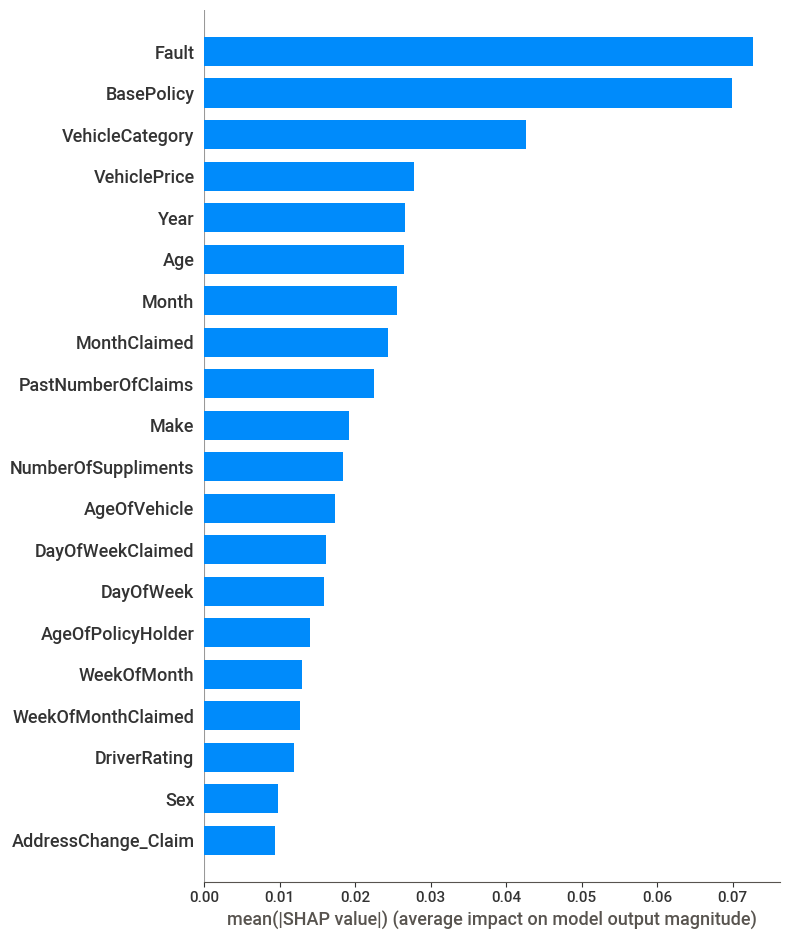


RESÚMEN GRÁFICO SHAP


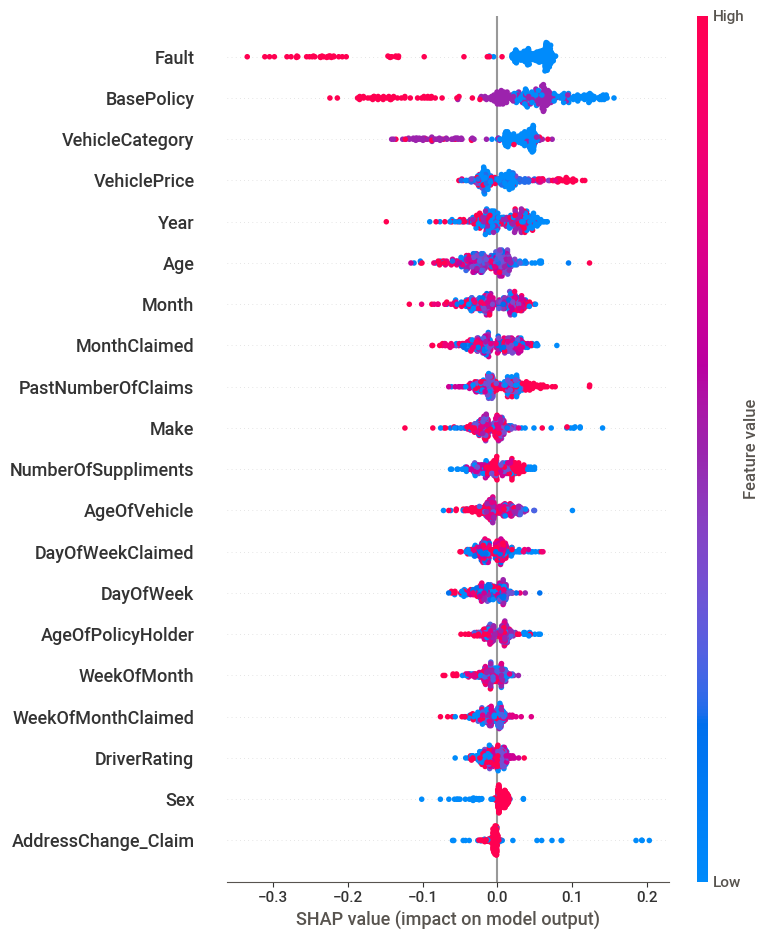


GRÁFICO DEPENDENCIA SHAP (AddressChange_Claim)


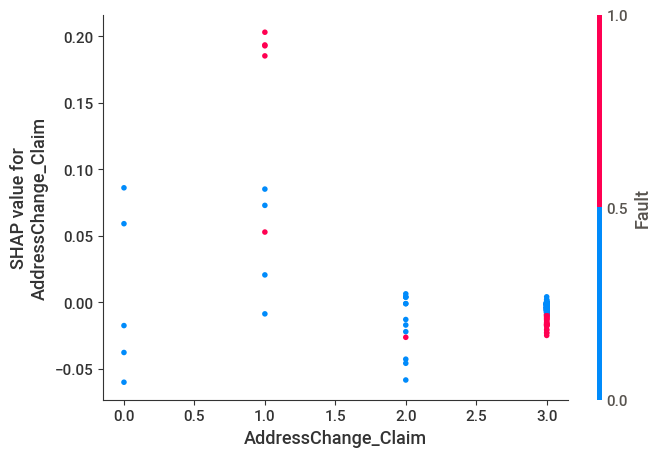

In [34]:
background = X_train_res.sample(300, random_state=42)
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(background)

print("SHAP valores calculados correctamente.")
print("\nSHAP IMPORTANCIA VARIABLES")
shap.summary_plot(shap_values[1], background, plot_type="bar")

print("\nRESÚMEN GRÁFICO SHAP")
shap.summary_plot(shap_values[1], background)

feature_to_plot = "AddressChange_Claim"  
print(f"\nGRÁFICO DEPENDENCIA SHAP ({feature_to_plot})")
shap.dependence_plot(feature_to_plot, shap_values[1], background)


## 5.2. LIME


Predicción del modelo
Probabilidad de FRAUDE: 0.006271676495637641

EXPLICACIÓN LIME
[('BasePolicy', -0.02746567823675726), ('VehicleCategory', -0.01254474212826371), ('Fault', -0.006538038555171226), ('AddressChange_Claim', 0.005579252553154438), ('Month', -0.0029442882369632812), ('MonthClaimed', -0.0020449366956547662), ('Sex', 0.0020060529380877537), ('PastNumberOfClaims', 0.0016446961030968294), ('VehiclePrice', 0.0013912742561785207), ('NumberOfSuppliments', 0.0007267002957629433)]


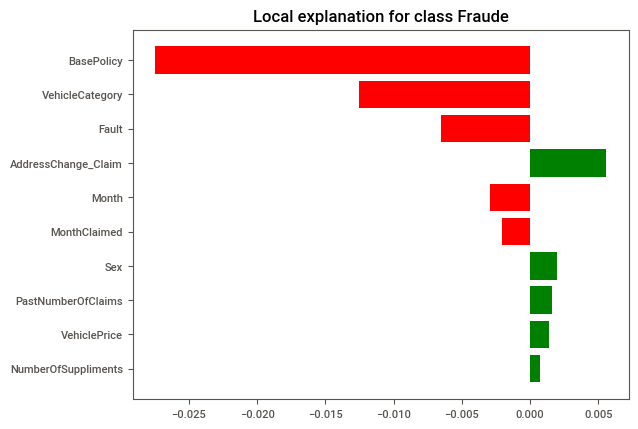

In [35]:
X_lime = X_train.copy().astype(float)
X_test_lime = X_test.copy().astype(float)

explainer_lime = LimeTabularExplainer(
    training_data=X_lime.values,
    feature_names=X_lime.columns.tolist(),
    class_names=["No Fraude", "Fraude"],
    mode="classification",
    discretize_continuous=False,   
    sample_around_instance=True,  
    random_state=42
)
i = 10
instance = X_test_lime.iloc[i].values.reshape(1, -1)

print("\nPredicción del modelo")
print("Probabilidad de FRAUDE:",
      best_rf.predict_proba(instance)[0,1])

exp = explainer_lime.explain_instance(
    data_row=X_test_lime.iloc[i].values,
    predict_fn=best_rf.predict_proba,
    num_features=10
)
print("\nEXPLICACIÓN LIME")
print(exp.as_list())

fig = exp.as_pyplot_figure() 
plt.show()


# 6. LIFT Y GAIN CHART

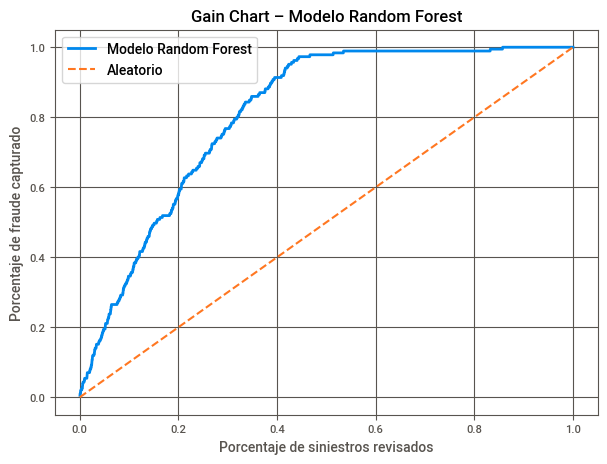

In [36]:
# Probabilidades del modelo final
y_scores = best_rf.predict_proba(X_test)[:, 1]

# DataFrame auxiliar
df_lift = pd.DataFrame({
    "y_true": y_test.values,
    "y_score": y_scores
})

# Ordenar por score descendente
df_lift = df_lift.sort_values("y_score", ascending=False).reset_index(drop=True)

# Total de fraudes
total_fraud = df_lift["y_true"].sum()

# Porcentaje acumulado de muestras
df_lift["cum_samples"] = (np.arange(1, len(df_lift) + 1)) / len(df_lift)

# Fraude acumulado capturado
df_lift["cum_fraud"] = df_lift["y_true"].cumsum()
df_lift["gain"] = df_lift["cum_fraud"] / total_fraud

# Lift
df_lift["lift"] = df_lift["gain"] / df_lift["cum_samples"]

# Gain chart 
plt.figure(figsize=(7, 5))
plt.plot(df_lift["cum_samples"], df_lift["gain"], label="Modelo Random Forest", linewidth=2)
plt.plot([0, 1], [0, 1], "--", label="Aleatorio")

plt.xlabel("Porcentaje de siniestros revisados")
plt.ylabel("Porcentaje de fraude capturado")
plt.title("Gain Chart – Modelo Random Forest")
plt.legend()
plt.grid(True)
plt.show()



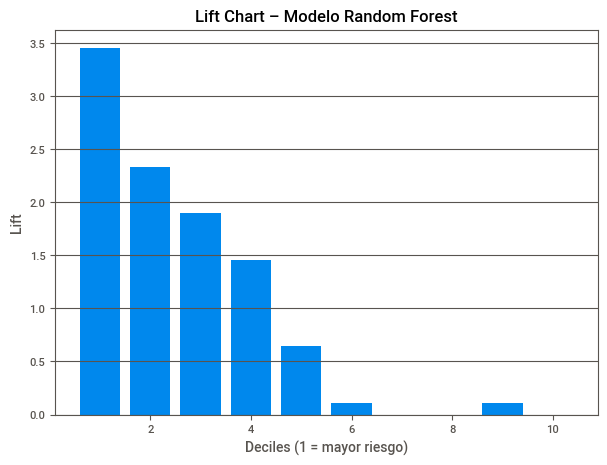

In [37]:
# Lift chart
df_lift["decile"] = pd.qcut(df_lift.index, 10, labels=False)

lift_deciles = df_lift.groupby("decile").agg(
    fraud_rate=("y_true", "mean")
).reset_index()

baseline = df_lift["y_true"].mean()
lift_deciles["lift"] = lift_deciles["fraud_rate"] / baseline

plt.figure(figsize=(7, 5))
plt.bar(lift_deciles["decile"] + 1, lift_deciles["lift"])

plt.xlabel("Deciles (1 = mayor riesgo)")
plt.ylabel("Lift")
plt.title("Lift Chart – Modelo Random Forest")
plt.grid(axis="y")
plt.show()


# 7. LLM

In [38]:
# Modelo LLM
os.environ["LLAMA_CPP_DISABLE_STD_REDIRECT"] = "1"
llm = Llama(
    model_path="models/mistral-7b-instruct.gguf",
    n_ctx=4096,
    n_threads=6,
    verbose=True
)

# Encoder
ordinal_mapping = {
    col: {
        cat: int(code)
        for cat, code in zip(encoder.categories_[i],
                             range(len(encoder.categories_[i])))
    }
    for i, col in enumerate(cat_cols)
}

# Tools
def run_local_llm(prompt: str):
    output = llm(
        prompt,
        max_tokens=512,
        temperature=0.2,
        top_p=0.95,
        stop=["</s>"]
    )
    return output["choices"][0]["text"].strip()

def parse_text_to_features(text: str, template: dict):

    # Construir lista de categorías válidas para cada columna categórica
    category_options = {
        col: list(cats)
        for col, cats in zip(cat_cols, encoder.categories_)
    }

    prompt = f"""
You extract structured categorical data from an insurance claim text.

RULES:
- Output MUST be valid JSON only.
- For each categorical feature, choose EXACTLY ONE value from the allowed list.
- If the text does not contain information for a feature → set it to null.
- NEVER invent categories.
- NEVER output numbers for categorical features.
- For numeric fields, extract the number if present, otherwise null.
- DO NOT add comments.
- DO NOT explain anything.

Text:
{text}

Allowed categories for each feature:
{json.dumps(category_options, indent=2)}

JSON template (keys only):
{json.dumps(template, indent=2)}

Return ONLY the final JSON:
"""

    out = run_local_llm(prompt)

    try:
        parsed = json.loads(out)
        return parsed
    except:
        raise ValueError("JSON inválido:\n" + out)


def map_categories_to_numeric(features: dict):

    mapped = {}

    for col in X.columns:

        val = features.get(col, None)
       
        if col in ordinal_mapping:

            if val in ordinal_mapping[col]:
                mapped[col] = ordinal_mapping[col][val]
            else:
                mapped[col] = -1  

        else:
            # convertir a float o 0 si no es válido
            try:
                mapped[col] = float(val)
            except:
                mapped[col] = 0  

    return mapped

def predict_fraud(features: dict):

    x = np.array([list(features.values())], dtype=float)
    prob = best_rf.predict_proba(x)[0, 1]

    return {
        "prediction": "Fraude" if prob >= best_thr else "No Fraude",
        "probability": float(prob)
    }

def explain_shap(features: dict):

    x = np.array([list(features.values())], dtype=float)
    shap_vals = explainer.shap_values(x)[1][0]

    top = np.argsort(np.abs(shap_vals))[::-1][:5]

    return [
        {"feature": list(features.keys())[i], "shap_value": float(shap_vals[i])}
        for i in top
    ]

# Agente experto
def fraud_agent_from_text(text: str):

    template = {col: None for col in X.columns}

    raw = parse_text_to_features(text, template)

    numeric_features = map_categories_to_numeric(raw)

    pred = predict_fraud(numeric_features)
    shap_exp = explain_shap(numeric_features)

    report_prompt = f"""
You are an insurance fraud analyst.

Case data:
{json.dumps(raw, indent=2)}

Numeric features used by the model:
{json.dumps(numeric_features, indent=2)}

Model prediction:
{json.dumps(pred, indent=2)}

SHAP most influential features:
{json.dumps(shap_exp, indent=2)}

Write a clear technical explanation.
"""

    return run_local_llm(report_prompt)


llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from models/mistral-7b-instruct.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.

## 6.2. TEST LLM

In [39]:
# Caso de fraude evidente
texto = """
The accident happened on a Saturday in July in an urban area.
The driver is a 16-year-old male, single, driving a Honda sedan.
The vehicle is new and valued at more than 69000.
The policyholder is between 16 and 20 years old.
The claimed accident was reported on a Tuesday in September, week 4.
The policyholder was at fault.
There were no previous claims, no police report, and no witnesses.
Deductible is 400. Driver rating is 1.
More than 30 days since last policy accident and claim.
No supplements. No address change. One vehicle.
Agent type external. Policy type All Perils.
"""
print(fraud_agent_from_text(texto))



llama_print_timings:        load time =   56322.02 ms
llama_print_timings:      sample time =      57.15 ms /   312 runs   (    0.18 ms per token,  5458.94 tokens per second)
llama_print_timings: prompt eval time =  191114.36 ms /  1727 tokens (  110.66 ms per token,     9.04 tokens per second)
llama_print_timings:        eval time =   53926.18 ms /   311 runs   (  173.40 ms per token,     5.77 tokens per second)
llama_print_timings:       total time =  247352.66 ms /  2038 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =   56322.02 ms
llama_print_timings:      sample time =      72.65 ms /   434 runs   (    0.17 ms per token,  5974.01 tokens per second)
llama_print_timings: prompt eval time =   98226.36 ms /   933 tokens (  105.28 ms per token,     9.50 tokens per second)
llama_print_timings:        eval time =   65708.11 ms /   433 runs   (  151.75 ms per token,     6.59 tokens per second)
llama_print_timings:       total time =  166343.03 ms /  1366 

The given case data represents the features of an insurance claim. The model used to analyze this claim is a machine learning model, specifically a Random Forest Classifier, which was trained on historical insurance claims data to predict whether a claim is fraudulent or not based on various features.

The model's prediction for the given case is that the claim has a high probability (0.5092812638342625) of being fraudulent. This prediction is based on the input features provided in the case data, which include the month, day of the week, make of the vehicle, accident area, day of the week claimed, month claimed, sex, marital status, age, fault, vehicle category, vehicle price, deductible, driver rating, days between policy accident and claim, past number of claims, age of the vehicle, age of the policy holder, police report filed, witness present, agent type, number of supplements, address change claim, number of cars, and base policy.

The SHAP (SHapley Additive exPlanations) values 

In [40]:
# Caso de no fraude
texto = """
The accident happened in a rural area on a Monday in March.
The driver is a 55-year-old married female.
The vehicle is 2 years old and its price category is “20000 to 29000”.
The policyholder was not at fault (“third party”).
A police report was filed and there were witnesses.
The claim was filed the same week of the accident.
No previous claims.
Deductible is 700 and the driver rating is 4.
The address has not changed (“no change”).
Only one vehicle is insured.
The agent type is internal.
The base policy is “Collision”.
"""
print(fraud_agent_from_text(texto))

Llama.generate: prefix-match hit

llama_print_timings:        load time =   56322.02 ms
llama_print_timings:      sample time =      82.78 ms /   313 runs   (    0.26 ms per token,  3781.24 tokens per second)
llama_print_timings: prompt eval time =  291378.01 ms /  1711 tokens (  170.30 ms per token,     5.87 tokens per second)
llama_print_timings:        eval time =  160669.75 ms /   312 runs   (  514.97 ms per token,     1.94 tokens per second)
llama_print_timings:       total time =  457481.93 ms /  2023 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =   56322.02 ms
llama_print_timings:      sample time =     270.46 ms /   512 runs   (    0.53 ms per token,  1893.07 tokens per second)
llama_print_timings: prompt eval time =  137184.07 ms /   936 tokens (  146.56 ms per token,     6.82 tokens per second)
llama_print_timings:        eval time =  186538.92 ms /   511 runs   (  365.05 ms per token,     2.74 tokens per second)
llama_print_timings:       to

This case involves analyzing the potential fraud in an automobile insurance claim based on the provided case data and model prediction. The case data consists of various features such as the month of the accident, day of the week, make of the vehicle, accident area, day of the week claimed, month claimed, week of the month claimed, sex of the policyholder, marital status, age, fault, vehicle category, vehicle price, deductible, driver rating, days between accident and claim, past number of claims, age of the vehicle, age of the policyholder, police report filed, witness present, agent type, number of supplements, address change claim, number of cars, year, and base policy.

The model used in this analysis is a machine learning model that predicts whether a claim is fraudulent or not based on the provided features. The model prediction for this case is "No Fraude" with a probability of 0.09960681520314547. This means that there is a relatively low probability that this claim is fraudule

In [41]:
# Caso con información incompleta
tecto= """
The driver is about 40 years old.
The accident happened in an urban zone but the exact day is unknown.
No information was provided about the month of the accident.
The vehicle is around 3 years old.
The policyholder says he is “not sure” about fault.
There were no witnesses.
Police report status was not mentioned.
No information about deductible or driver rating.
The claim was filed several weeks later.
"""
print(fraud_agent_from_text(texto))

Llama.generate: prefix-match hit

llama_print_timings:        load time =   56322.02 ms
llama_print_timings:      sample time =      81.81 ms /   313 runs   (    0.26 ms per token,  3825.70 tokens per second)
llama_print_timings: prompt eval time =  219515.21 ms /  1711 tokens (  128.30 ms per token,     7.79 tokens per second)
llama_print_timings:        eval time =  151195.96 ms /   312 runs   (  484.60 ms per token,     2.06 tokens per second)
llama_print_timings:       total time =  377271.28 ms /  2023 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =   56322.02 ms
llama_print_timings:      sample time =     267.37 ms /   512 runs   (    0.52 ms per token,  1914.94 tokens per second)
llama_print_timings: prompt eval time =  133006.60 ms /   936 tokens (  142.10 ms per token,     7.04 tokens per second)
llama_print_timings:        eval time =  226077.66 ms /   511 runs   (  442.42 ms per token,     2.26 tokens per second)
llama_print_timings:       to

The given case data represents an insurance claim with various attributes such as month, day of the week, make of the vehicle, accident area, day of week claimed, month claimed, week of month claimed, sex, marital status, age, fault, vehicle category, vehicle price, deductible, driver rating, days policy accident, days policy claim, past number of claims, age of vehicle, age of policy holder, police report filed, witness present, agent type, number of supplements, address change claim, number of cars, year, and base policy.

The model used for analysis is a machine learning model that predicts whether a claim is a fraud or not based on the given features. The model takes the numeric features as inputs and predicts the probability of fraud. In this case, the model predicted that the claim is not a fraud with a probability of 0.09960681520314547.

The SHAP (SHapley Additive exPlanations) values represent the contribution of each feature towards the prediction of the model. The feature wi

In [42]:
# Caso con contradicciones
texto= """
The accident took place in July on a Saturday.
The driver is a 30-year-old male.
The report says there were no witnesses, but later mentions “one witness confirmed the event”.
The police report is first stated as “not filed” and later as “a police report confirmed the details”.
The vehicle is 7 years old.
The policyholder is declared responsible for the accident.
The deductible is 400.
The base policy is “All Perils”.
"""
print(fraud_agent_from_text(texto))


Llama.generate: prefix-match hit

llama_print_timings:        load time =   56322.02 ms
llama_print_timings:      sample time =      54.43 ms /   274 runs   (    0.20 ms per token,  5033.99 tokens per second)
llama_print_timings: prompt eval time =  341194.73 ms /  1670 tokens (  204.31 ms per token,     4.89 tokens per second)
llama_print_timings:        eval time =   54928.28 ms /   273 runs   (  201.20 ms per token,     4.97 tokens per second)
llama_print_timings:       total time =  398431.12 ms /  1943 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =   56322.02 ms
llama_print_timings:      sample time =     105.50 ms /   512 runs   (    0.21 ms per token,  4852.90 tokens per second)
llama_print_timings: prompt eval time =  168339.51 ms /   893 tokens (  188.51 ms per token,     5.30 tokens per second)
llama_print_timings:        eval time =   97436.82 ms /   511 runs   (  190.68 ms per token,     5.24 tokens per second)
llama_print_timings:       to

This case analysis involves the examination of a single record of an auto insurance claim. The goal is to determine if the claim represents an instance of fraud based on various features of the claim. The features include the day of the week and month of the accident and claim, demographic information of the policyholder, details of the accident and claim, and other relevant factors.

First, the case data is preprocessed to convert categorical features into numerical representations using techniques such as one-hot encoding or ordinal encoding. In this case, the 'Month' and 'DayOfWeek' features were left as is since they are already numerical. The 'Fault', 'MaritalStatus', 'VehicleCategory', 'AgentType', and 'AddressChange_Claim' features were encoded as -1 to represent the absence of the respective condition or category. The 'Sex' feature was encoded as 1 for Male and -1 for Female. The 'BasePolicy' feature was encoded as 0 for 'All Perils'.

Next, the preprocessed features were fed i